In [1]:
!pip install torchinfo

In [2]:
import os
os.chdir("/content/drive/MyDrive/RiverSemanticSegmentation/")
dataset_dir = os.path.normpath("/content/drive/MyDrive/SemanticSegmentationV2/dataset/")

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from dataloader import Dataset
from torchinfo import summary
import time
import copy

from tqdm import tqdm

from models.unet import UNet
from models.simple import Simple

from dataloader import Dataset

In [4]:
PARAMS = {
    "input_size": 416,
    "model": "vgg_unet",
    "learning_rate": 0.01,
    "batch_size": 2,
    'epochs': 500,
    "train_dataset_size": 2,
    "test_dataset_size": 2,
}

In [5]:
!pip install neptune-client
import neptune

neptune.init(project_qualified_name='radek/pth1',
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmY4YjQ3YjEtNmY5My00MDc2LWI4NzAtMWE5MmUwZjQ1NDE2In0=',
             )

# Create experiment
neptune.create_experiment(params=PARAMS)


https://ui.neptune.ai/radek/pth1/e/PTH1-7


Experiment(PTH1-7)

In [6]:
x_train_dir = os.path.join(dataset_dir,"x_train")
y_train_dir = os.path.join(dataset_dir,"y_train")
x_test_dir = os.path.join(dataset_dir,"x_test")
y_test_dir = os.path.join(dataset_dir,"y_test")

In [7]:
train_set = Dataset(x_train_dir, y_train_dir, PARAMS['input_size'], PARAMS["train_dataset_size"])
test_set = Dataset(x_test_dir, y_test_dir, PARAMS['input_size'], PARAMS["test_dataset_size"])
batch_size = PARAMS['batch_size']
dataloaders = {
    'train': DataLoader(train_set, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=0),
    'val': DataLoader(test_set, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=0)
}


In [8]:
if PARAMS['model'] == "simple":
  from models.simple import Simple
  model = Simple()
elif PARAMS['model'] == "vgg_unet":
  from models.vgg_unet import VggUnet
  model = VggUnet()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(PARAMS['batch_size'], 3, PARAMS['input_size'], PARAMS['input_size']))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [2, 64, 416, 416]         --
|    └─Conv2d: 2-1                       [2, 64, 416, 416]         1,792
|    └─ReLU: 2-2                         [2, 64, 416, 416]         --
|    └─Conv2d: 2-3                       [2, 64, 416, 416]         36,928
|    └─ReLU: 2-4                         [2, 64, 416, 416]         --
├─MaxPool2d: 1-2                         [2, 64, 208, 208]         --
├─Sequential: 1-3                        [2, 128, 208, 208]        --
|    └─Conv2d: 2-5                       [2, 128, 208, 208]        73,856
|    └─ReLU: 2-6                         [2, 128, 208, 208]        --
|    └─Conv2d: 2-7                       [2, 128, 208, 208]        147,584
|    └─ReLU: 2-8                         [2, 128, 208, 208]        --
├─MaxPool2d: 1-4                         [2, 128, 104, 104]        --
├─Sequential: 1-5                        [2, 256, 104, 104]        --

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [2, 64, 416, 416]         --
|    └─Conv2d: 2-1                       [2, 64, 416, 416]         1,792
|    └─ReLU: 2-2                         [2, 64, 416, 416]         --
|    └─Conv2d: 2-3                       [2, 64, 416, 416]         36,928
|    └─ReLU: 2-4                         [2, 64, 416, 416]         --
├─MaxPool2d: 1-2                         [2, 64, 208, 208]         --
├─Sequential: 1-3                        [2, 128, 208, 208]        --
|    └─Conv2d: 2-5                       [2, 128, 208, 208]        73,856
|    └─ReLU: 2-6                         [2, 128, 208, 208]        --
|    └─Conv2d: 2-7                       [2, 128, 208, 208]        147,584
|    └─ReLU: 2-8                         [2, 128, 208, 208]        --
├─MaxPool2d: 1-4                         [2, 128, 104, 104]        --
├─Sequential: 1-5                        [2, 256, 104, 104]        --

In [9]:
from collections import defaultdict
import torch.nn.functional as F
SMOOTH = 1e-6
def iou_metric(outputs: torch.Tensor, labels: torch.Tensor):
    #print(outputs.min())
    #print(labels.min())
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)
    intersection = (outputs * labels).sum(2).sum(1)  # Will be zero if Truth=0 or Prediction=0
    union = (outputs + labels).sum(2).sum(1) - intersection  # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou.mean()
    

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    pred = torch.round(pred)
    dice = dice_loss(pred, target)
    loss = bce# * bce_weight + dice * (1 - bce_weight)
    iou = iou_metric(pred, target)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics['iou'] += iou.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):   
    print(epoch_samples) 
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        neptune.log_metric(phase+"_"+k, metrics[k] / epoch_samples) #log
    print("{}: {}".format(phase, ", ".join(outputs)))    



In [10]:
#from metrics import *

def train_model(model, dataloaders, optimizer, device, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'eval' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
optimizer_ft = optim.Adam(model.parameters(), lr=PARAMS['learning_rate'])
model = train_model(model, dataloaders, optimizer_ft, device, num_epochs=PARAMS['epochs'])

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0/499
----------
LR 0.01


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

2



100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

train: bce: 0.739066, dice: 0.940100, loss: 0.739066, iou: 0.030942
saving best model
2



  0%|          | 0/1 [00:00<?, ?it/s]

val: bce: 30853619712.000000, dice: 0.732183, loss: 30853619712.000000, iou: 0.166183
0m 2s
Epoch 1/499
----------
LR 0.01
2
train: bce: 1.293048, dice: 0.855651, loss: 1.293048, iou: 0.078056


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 12406680.000000, dice: 0.756049, loss: 12406680.000000, iou: 0.154159
0m 0s
Epoch 2/499
----------
LR 0.01
2
train: bce: 0.902371, dice: 0.969229, loss: 0.902371, iou: 0.015718


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 42084.550781, dice: 0.968659, loss: 42084.550781, iou: 0.016019
0m 0s
Epoch 3/499
----------
LR 0.01
2
train: bce: 0.730741, dice: 0.862620, loss: 0.730741, iou: 0.074649
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 13143116.000000, dice: 0.704819, loss: 13143116.000000, iou: 0.181996
0m 0s
Epoch 4/499
----------
LR 0.01
2
train: bce: 0.706686, dice: 0.862257, loss: 0.706686, iou: 0.074002
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 272523.875000, dice: 0.999746, loss: 272523.875000, iou: 0.000102
0m 0s
Epoch 5/499
----------
LR 0.01
2
train: bce: 0.616811, dice: 0.866586, loss: 0.616811, iou: 0.072467
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11.984491, dice: 0.998569, loss: 11.984491, iou: 0.000692
0m 0s
Epoch 6/499
----------
LR 0.01
2
train: bce: 0.602014, dice: 0.961488, loss: 0.602014, iou: 0.019759
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.855877, dice: 0.999829, loss: 1.855877, iou: 0.000054
0m 0s
Epoch 7/499
----------
LR 0.01
2
train: bce: 0.557112, dice: 0.940390, loss: 0.557112, iou: 0.030927
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.498538, dice: 0.944704, loss: 0.498538, iou: 0.028404
0m 0s
Epoch 8/499
----------
LR 0.01
2
train: bce: 0.516677, dice: 0.947245, loss: 0.516677, iou: 0.027037
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6456.040039, dice: 0.481015, loss: 6456.040039, iou: 0.353865
0m 0s
Epoch 9/499
----------
LR 0.01
2
train: bce: 0.481718, dice: 0.989995, loss: 0.481718, iou: 0.004990
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1809823.125000, dice: 0.486458, loss: 1809823.125000, iou: 0.347659
0m 0s
Epoch 10/499
----------
LR 0.01
2
train: bce: 0.431778, dice: 0.990513, loss: 0.431778, iou: 0.004691
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.494622, dice: 0.997056, loss: 0.494622, iou: 0.001445
0m 0s
Epoch 11/499
----------
LR 0.01
2
train: bce: 0.381780, dice: 0.991636, loss: 0.381780, iou: 0.004130
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6.047112, dice: 0.999928, loss: 6.047112, iou: 0.000010
0m 0s
Epoch 12/499
----------
LR 0.01
2
train: bce: 0.338093, dice: 0.992060, loss: 0.338093, iou: 0.003919
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.457248, dice: 0.999946, loss: 0.457248, iou: 0.000000
0m 0s
Epoch 13/499
----------
LR 0.01
2
train: bce: 0.292999, dice: 0.999476, loss: 0.292999, iou: 0.000186
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.432370, dice: 0.999938, loss: 0.432370, iou: 0.000000
0m 0s
Epoch 14/499
----------
LR 0.01
2
train: bce: 0.249721, dice: 0.999837, loss: 0.249721, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.420450, dice: 0.999934, loss: 0.420450, iou: 0.000000
0m 0s
Epoch 15/499
----------
LR 0.01
2
train: bce: 0.216494, dice: 0.999835, loss: 0.216494, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.397327, dice: 0.999935, loss: 0.397327, iou: 0.000000
0m 0s
Epoch 16/499
----------
LR 0.01
2
train: bce: 0.191213, dice: 0.999835, loss: 0.191213, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.394943, dice: 0.999937, loss: 0.394943, iou: 0.000000
0m 0s
Epoch 17/499
----------
LR 0.01
2
train: bce: 0.171321, dice: 0.999836, loss: 0.171321, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.418508, dice: 0.999938, loss: 0.418508, iou: 0.000000
0m 0s
Epoch 18/499
----------
LR 0.01
2
train: bce: 0.157905, dice: 0.999837, loss: 0.157905, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.427240, dice: 0.999938, loss: 0.427240, iou: 0.000000
0m 0s
Epoch 19/499
----------
LR 0.01
2
train: bce: 0.150327, dice: 0.999836, loss: 0.150327, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.402440, dice: 0.999937, loss: 0.402440, iou: 0.000000
0m 0s
Epoch 20/499
----------
LR 0.01
2
train: bce: 0.145763, dice: 0.999835, loss: 0.145763, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.397118, dice: 0.962895, loss: 0.397118, iou: 0.018957
0m 0s
Epoch 21/499
----------
LR 0.01
2
train: bce: 0.142048, dice: 0.999835, loss: 0.142048, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.525568, dice: 0.493001, loss: 0.525568, iou: 0.341795
0m 0s
Epoch 22/499
----------
LR 0.01
2
train: bce: 0.140214, dice: 0.999835, loss: 0.140214, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.378649, dice: 0.983950, loss: 0.378649, iou: 0.008067
0m 0s
Epoch 23/499
----------
LR 0.01
2
train: bce: 0.141546, dice: 0.999835, loss: 0.141546, iou: 0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.396126, dice: 0.999933, loss: 0.396126, iou: 0.000000
0m 0s
Epoch 24/499
----------
LR 0.01
2
train: bce: 0.142156, dice: 0.999835, loss: 0.142156, iou: 0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.452476, dice: 0.999933, loss: 0.452476, iou: 0.000000
0m 0s
Epoch 25/499
----------
LR 0.01
2
train: bce: 0.141907, dice: 0.999835, loss: 0.141907, iou: 0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.528741, dice: 0.999933, loss: 0.528741, iou: 0.000000
0m 0s
Epoch 26/499
----------
LR 0.01
2
train: bce: 0.142447, dice: 0.999835, loss: 0.142447, iou: 0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.521439, dice: 0.999933, loss: 0.521439, iou: 0.000000
0m 0s
Epoch 27/499
----------
LR 0.01
2
train: bce: 0.139923, dice: 0.999835, loss: 0.139923, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.663521, dice: 0.999933, loss: 0.663521, iou: 0.000000
0m 0s
Epoch 28/499
----------
LR 0.01
2
train: bce: 0.143549, dice: 0.999835, loss: 0.143549, iou: 0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.454738, dice: 0.800776, loss: 0.454738, iou: 0.113835
0m 0s
Epoch 29/499
----------
LR 0.01
2
train: bce: 0.137344, dice: 0.999835, loss: 0.137344, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.523292, dice: 0.668650, loss: 0.523292, iou: 0.212966
0m 0s
Epoch 30/499
----------
LR 0.01
2
train: bce: 0.135038, dice: 0.999835, loss: 0.135038, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.456360, dice: 0.913271, loss: 0.456360, iou: 0.045493
0m 0s
Epoch 31/499
----------
LR 0.01
2
train: bce: 0.131462, dice: 0.999835, loss: 0.131462, iou: 0.000000
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.496499, dice: 0.996985, loss: 0.496499, iou: 0.001477
0m 0s
Epoch 32/499
----------
LR 0.01
2
train: bce: 0.127239, dice: 0.999091, loss: 0.127239, iou: 0.000373
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.509242, dice: 0.980396, loss: 0.509242, iou: 0.009909
0m 0s
Epoch 33/499
----------
LR 0.01
2
train: bce: 0.122044, dice: 0.988204, loss: 0.122044, iou: 0.005853
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.935130, dice: 0.644579, loss: 0.935130, iou: 0.216867
0m 0s
Epoch 34/499
----------
LR 0.01
2
train: bce: 0.114945, dice: 0.956382, loss: 0.114945, iou: 0.022239
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.733202, dice: 0.621391, loss: 1.733202, iou: 0.235314
0m 0s
Epoch 35/499
----------
LR 0.01
2
train: bce: 0.100920, dice: 0.930835, loss: 0.100920, iou: 0.035780
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.948960, dice: 0.999934, loss: 1.948960, iou: 0.000000
0m 0s
Epoch 36/499
----------
LR 0.01
2
train: bce: 0.106378, dice: 0.944458, loss: 0.106378, iou: 0.028604


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 0.755200, dice: 0.987170, loss: 0.755200, iou: 0.006450
0m 0s
Epoch 37/499
----------
LR 0.01
2
train: bce: 0.102882, dice: 0.942874, loss: 0.102882, iou: 0.029445


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.974493, dice: 0.643290, loss: 1.974493, iou: 0.220126
0m 0s
Epoch 38/499
----------
LR 0.01
2
train: bce: 0.097852, dice: 0.855350, loss: 0.097852, iou: 0.077986
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.375858, dice: 0.788087, loss: 1.375858, iou: 0.123167
0m 0s
Epoch 39/499
----------
LR 0.01
2
train: bce: 0.097396, dice: 0.685884, loss: 0.097396, iou: 0.190082
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.642771, dice: 0.999936, loss: 2.642771, iou: 0.000000
0m 0s
Epoch 40/499
----------
LR 0.01
2
train: bce: 0.091377, dice: 0.905911, loss: 0.091377, iou: 0.049297
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.530267, dice: 0.999919, loss: 2.530267, iou: 0.000010
0m 0s
Epoch 41/499
----------
LR 0.01
2
train: bce: 0.092770, dice: 0.964288, loss: 0.092770, iou: 0.018245


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6.052925, dice: 0.647487, loss: 6.052925, iou: 0.217289
0m 0s
Epoch 42/499
----------
LR 0.01
2
train: bce: 0.089916, dice: 0.350159, loss: 0.089916, iou: 0.481709
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8.247375, dice: 0.865074, loss: 8.247375, iou: 0.073399
0m 0s
Epoch 43/499
----------
LR 0.01
2
train: bce: 0.088126, dice: 0.324982, loss: 0.088126, iou: 0.510427
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 12.833040, dice: 0.999934, loss: 12.833040, iou: 0.000000
0m 0s
Epoch 44/499
----------
LR 0.01
2
train: bce: 0.106550, dice: 0.999359, loss: 0.106550, iou: 0.000238


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 38.456890, dice: 0.675915, loss: 38.456890, iou: 0.199071
0m 0s
Epoch 45/499
----------
LR 0.01
2
train: bce: 0.099677, dice: 0.714333, loss: 0.099677, iou: 0.178145


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 86.576767, dice: 0.636533, loss: 86.576767, iou: 0.224727
0m 0s
Epoch 46/499
----------
LR 0.01
2
train: bce: 0.102678, dice: 0.316908, loss: 0.102678, iou: 0.519976


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 36.571507, dice: 0.999820, loss: 36.571507, iou: 0.000057
0m 0s
Epoch 47/499
----------
LR 0.01
2
train: bce: 0.096821, dice: 0.945324, loss: 0.096821, iou: 0.028131


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 70.052971, dice: 0.999935, loss: 70.052971, iou: 0.000000
0m 0s
Epoch 48/499
----------
LR 0.01
2
train: bce: 0.104635, dice: 0.968845, loss: 0.104635, iou: 0.015826


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6.817311, dice: 0.998743, loss: 6.817311, iou: 0.000606
0m 0s
Epoch 49/499
----------
LR 0.01
2
train: bce: 0.099545, dice: 0.952907, loss: 0.099545, iou: 0.024187


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.288664, dice: 0.976354, loss: 1.288664, iou: 0.011959
0m 0s
Epoch 50/499
----------
LR 0.01
2
train: bce: 0.096529, dice: 0.757116, loss: 0.096529, iou: 0.143526


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.576506, dice: 0.949711, loss: 1.576506, iou: 0.025821
0m 0s
Epoch 51/499
----------
LR 0.01
2
train: bce: 0.099470, dice: 0.540430, loss: 0.099470, iou: 0.308113


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.256268, dice: 0.988461, loss: 1.256268, iou: 0.005792
0m 0s
Epoch 52/499
----------
LR 0.01
2
train: bce: 0.099110, dice: 0.537689, loss: 0.099110, iou: 0.310793


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.060741, dice: 0.994801, loss: 1.060741, iou: 0.002589
0m 0s
Epoch 53/499
----------
LR 0.01
2
train: bce: 0.096954, dice: 0.731092, loss: 0.096954, iou: 0.162438


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.017188, dice: 0.992409, loss: 1.017188, iou: 0.003795
0m 0s
Epoch 54/499
----------
LR 0.01
2
train: bce: 0.095421, dice: 0.843090, loss: 0.095421, iou: 0.085951


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.107987, dice: 0.977378, loss: 1.107987, iou: 0.011431
0m 0s
Epoch 55/499
----------
LR 0.01
2
train: bce: 0.094604, dice: 0.853786, loss: 0.094604, iou: 0.079547


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.144951, dice: 0.960445, loss: 1.144951, iou: 0.020166
0m 0s
Epoch 56/499
----------
LR 0.01
2
train: bce: 0.094874, dice: 0.873699, loss: 0.094874, iou: 0.067757


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.095820, dice: 0.960232, loss: 1.095820, iou: 0.020276
0m 0s
Epoch 57/499
----------
LR 0.01
2
train: bce: 0.095416, dice: 0.894226, loss: 0.095416, iou: 0.055899


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.170195, dice: 0.936205, loss: 1.170195, iou: 0.032971
0m 0s
Epoch 58/499
----------
LR 0.01
2
train: bce: 0.095020, dice: 0.869359, loss: 0.095020, iou: 0.070387


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.173841, dice: 0.947281, loss: 1.173841, iou: 0.027070
0m 0s
Epoch 59/499
----------
LR 0.01
2
train: bce: 0.094297, dice: 0.800508, loss: 0.094297, iou: 0.114391


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.120739, dice: 0.962879, loss: 1.120739, iou: 0.018901
0m 0s
Epoch 60/499
----------
LR 0.01
2
train: bce: 0.093822, dice: 0.761386, loss: 0.093822, iou: 0.142486


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.260214, dice: 0.954645, loss: 1.260214, iou: 0.023194
0m 0s
Epoch 61/499
----------
LR 0.01
2
train: bce: 0.092822, dice: 0.646804, loss: 0.092822, iou: 0.233290


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.195386, dice: 0.977861, loss: 1.195386, iou: 0.011188
0m 0s
Epoch 62/499
----------
LR 0.01
2
train: bce: 0.092311, dice: 0.613886, loss: 0.092311, iou: 0.260002


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.118538, dice: 0.989392, loss: 1.118538, iou: 0.005322
0m 0s
Epoch 63/499
----------
LR 0.01
2
train: bce: 0.091848, dice: 0.636284, loss: 0.091848, iou: 0.241902


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.175205, dice: 0.988370, loss: 1.175205, iou: 0.005840
0m 0s
Epoch 64/499
----------
LR 0.01
2
train: bce: 0.091595, dice: 0.641105, loss: 0.091595, iou: 0.238258


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.288291, dice: 0.982825, loss: 1.288291, iou: 0.008657
0m 0s
Epoch 65/499
----------
LR 0.01
2
train: bce: 0.091401, dice: 0.628904, loss: 0.091401, iou: 0.248336


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.335417, dice: 0.977642, loss: 1.335417, iou: 0.011300
0m 0s
Epoch 66/499
----------
LR 0.01
2
train: bce: 0.091125, dice: 0.637836, loss: 0.091125, iou: 0.241789


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.388732, dice: 0.970435, loss: 1.388732, iou: 0.015004
0m 0s
Epoch 67/499
----------
LR 0.01
2
train: bce: 0.090610, dice: 0.650279, loss: 0.090610, iou: 0.232517


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.492265, dice: 0.954801, loss: 1.492265, iou: 0.023122
0m 0s
Epoch 68/499
----------
LR 0.01
2
train: bce: 0.090093, dice: 0.661643, loss: 0.090093, iou: 0.223963


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.721373, dice: 0.915557, loss: 1.721373, iou: 0.044113
0m 0s
Epoch 69/499
----------
LR 0.01
2
train: bce: 0.089684, dice: 0.644830, loss: 0.089684, iou: 0.238302


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.947023, dice: 0.878298, loss: 1.947023, iou: 0.065088
0m 0s
Epoch 70/499
----------
LR 0.01
2
train: bce: 0.089010, dice: 0.596004, loss: 0.089010, iou: 0.277586


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.759800, dice: 0.902108, loss: 1.759800, iou: 0.051531
0m 0s
Epoch 71/499
----------
LR 0.01
2
train: bce: 0.088672, dice: 0.589101, loss: 0.088672, iou: 0.284188


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.757541, dice: 0.902367, loss: 1.757541, iou: 0.051377
0m 0s
Epoch 72/499
----------
LR 0.01
2
train: bce: 0.088692, dice: 0.590119, loss: 0.088692, iou: 0.283925


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.755733, dice: 0.920022, loss: 1.755733, iou: 0.041656
0m 0s
Epoch 73/499
----------
LR 0.01
2
train: bce: 0.088329, dice: 0.562151, loss: 0.088329, iou: 0.305953


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.598548, dice: 0.954582, loss: 1.598548, iou: 0.023262
0m 0s
Epoch 74/499
----------
LR 0.01
2
train: bce: 0.088024, dice: 0.574087, loss: 0.088024, iou: 0.297365
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.549248, dice: 0.966152, loss: 1.549248, iou: 0.017249
0m 0s
Epoch 75/499
----------
LR 0.01
2
train: bce: 0.087651, dice: 0.597400, loss: 0.087651, iou: 0.279024
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.707131, dice: 0.966081, loss: 2.707131, iou: 0.017284
0m 0s
Epoch 76/499
----------
LR 0.01
2
train: bce: 0.087191, dice: 0.592976, loss: 0.087191, iou: 0.283165
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5.556008, dice: 0.965681, loss: 5.556008, iou: 0.017492
0m 0s
Epoch 77/499
----------
LR 0.01
2
train: bce: 0.086817, dice: 0.588736, loss: 0.086817, iou: 0.286756
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8.840820, dice: 0.964275, loss: 8.840820, iou: 0.018225
0m 0s
Epoch 78/499
----------
LR 0.01
2
train: bce: 0.086447, dice: 0.589058, loss: 0.086447, iou: 0.286640
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 13.907541, dice: 0.950299, loss: 13.907541, iou: 0.025513
0m 0s
Epoch 79/499
----------
LR 0.01
2
train: bce: 0.086042, dice: 0.561903, loss: 0.086042, iou: 0.307684
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 21.224293, dice: 0.936010, loss: 21.224293, iou: 0.033054
0m 0s
Epoch 80/499
----------
LR 0.01
2
train: bce: 0.085702, dice: 0.534035, loss: 0.085702, iou: 0.329352
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 30.040236, dice: 0.930503, loss: 30.040236, iou: 0.035996
0m 0s
Epoch 81/499
----------
LR 0.01
2
train: bce: 0.085218, dice: 0.524940, loss: 0.085218, iou: 0.337359
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 43.358376, dice: 0.894900, loss: 43.358376, iou: 0.055524
0m 0s
Epoch 82/499
----------
LR 0.01
2
train: bce: 0.084884, dice: 0.512701, loss: 0.084884, iou: 0.347737
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 57.517170, dice: 0.893656, loss: 57.517170, iou: 0.056225
0m 0s
Epoch 83/499
----------
LR 0.01
2
train: bce: 0.084524, dice: 0.488484, loss: 0.084524, iou: 0.366042
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 32.126125, dice: 0.855990, loss: 32.126125, iou: 0.078050
0m 0s
Epoch 84/499
----------
LR 0.01
2
train: bce: 0.084816, dice: 0.450051, loss: 0.084816, iou: 0.397484


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.232911, dice: 0.865667, loss: 3.232911, iou: 0.072398
0m 0s
Epoch 85/499
----------
LR 0.01
2
train: bce: 0.084932, dice: 0.459368, loss: 0.084932, iou: 0.389833


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.081018, dice: 0.977202, loss: 2.081018, iou: 0.011563
0m 0s
Epoch 86/499
----------
LR 0.01
2
train: bce: 0.083848, dice: 0.510770, loss: 0.083848, iou: 0.350607
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.605573, dice: 0.987465, loss: 2.605573, iou: 0.006311
0m 0s
Epoch 87/499
----------
LR 0.01
2
train: bce: 0.083684, dice: 0.594857, loss: 0.083684, iou: 0.287181
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6.664928, dice: 0.937585, loss: 6.664928, iou: 0.032231
0m 0s
Epoch 88/499
----------
LR 0.01
2
train: bce: 0.087075, dice: 0.600958, loss: 0.087075, iou: 0.283709


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.355614, dice: 0.999755, loss: 1.355614, iou: 0.000094
0m 0s
Epoch 89/499
----------
LR 0.01
2
train: bce: 0.084708, dice: 0.629965, loss: 0.084708, iou: 0.255029


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.374717, dice: 0.982967, loss: 1.374717, iou: 0.008603
0m 0s
Epoch 90/499
----------
LR 0.01
2
train: bce: 0.084470, dice: 0.592828, loss: 0.084470, iou: 0.286362


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.934932, dice: 0.918066, loss: 1.934932, iou: 0.042710
0m 0s
Epoch 91/499
----------
LR 0.01
2
train: bce: 0.083812, dice: 0.510499, loss: 0.083812, iou: 0.353804


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.285111, dice: 0.870076, loss: 2.285111, iou: 0.069738
0m 0s
Epoch 92/499
----------
LR 0.01
2
train: bce: 0.084333, dice: 0.428830, loss: 0.084333, iou: 0.419667


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.867791, dice: 0.915937, loss: 1.867791, iou: 0.043868
0m 0s
Epoch 93/499
----------
LR 0.01
2
train: bce: 0.084044, dice: 0.433712, loss: 0.084044, iou: 0.415165


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.622652, dice: 0.939089, loss: 1.622652, iou: 0.031449
0m 0s
Epoch 94/499
----------
LR 0.01
2
train: bce: 0.084976, dice: 0.502308, loss: 0.084976, iou: 0.361273


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.928270, dice: 0.933082, loss: 1.928270, iou: 0.034632
0m 0s
Epoch 95/499
----------
LR 0.01
2
train: bce: 0.083019, dice: 0.421675, loss: 0.083019, iou: 0.427034
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.425153, dice: 0.980973, loss: 1.425153, iou: 0.009618
0m 0s
Epoch 96/499
----------
LR 0.01
2
train: bce: 0.082095, dice: 0.488703, loss: 0.082095, iou: 0.373491
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.307556, dice: 0.987826, loss: 1.307556, iou: 0.006124
0m 0s
Epoch 97/499
----------
LR 0.01
2
train: bce: 0.082188, dice: 0.575377, loss: 0.082188, iou: 0.305794


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.753712, dice: 0.942952, loss: 1.753712, iou: 0.029410
0m 0s
Epoch 98/499
----------
LR 0.01
2
train: bce: 0.082104, dice: 0.591298, loss: 0.082104, iou: 0.293704


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.100821, dice: 0.676604, loss: 3.100821, iou: 0.198392
0m 0s
Epoch 99/499
----------
LR 0.01
2
train: bce: 0.080930, dice: 0.526202, loss: 0.080930, iou: 0.346635
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.477138, dice: 0.674434, loss: 3.477138, iou: 0.199901
0m 0s
Epoch 100/499
----------
LR 0.01
2
train: bce: 0.081730, dice: 0.502570, loss: 0.081730, iou: 0.364413


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.996320, dice: 0.667965, loss: 2.996320, iou: 0.203893
0m 0s
Epoch 101/499
----------
LR 0.01
2
train: bce: 0.081399, dice: 0.482575, loss: 0.081399, iou: 0.379156


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.933583, dice: 0.878632, loss: 1.933583, iou: 0.064733
0m 0s
Epoch 102/499
----------
LR 0.01
2
train: bce: 0.081991, dice: 0.538407, loss: 0.081991, iou: 0.335169


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.784967, dice: 0.963945, loss: 1.784967, iou: 0.018414
0m 0s
Epoch 103/499
----------
LR 0.01
2
train: bce: 0.079803, dice: 0.412002, loss: 0.079803, iou: 0.437780
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.509205, dice: 0.989694, loss: 1.509205, iou: 0.005184
0m 0s
Epoch 104/499
----------
LR 0.01
2
train: bce: 0.079754, dice: 0.418991, loss: 0.079754, iou: 0.432585
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.602955, dice: 0.975163, loss: 1.602955, iou: 0.012621
0m 0s
Epoch 105/499
----------
LR 0.01
2
train: bce: 0.078548, dice: 0.454749, loss: 0.078548, iou: 0.404371
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.902651, dice: 0.939289, loss: 1.902651, iou: 0.031330
0m 0s
Epoch 106/499
----------
LR 0.01
2
train: bce: 0.077166, dice: 0.482211, loss: 0.077166, iou: 0.383586
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.483507, dice: 0.974700, loss: 1.483507, iou: 0.012873
0m 0s
Epoch 107/499
----------
LR 0.01
2
train: bce: 0.078826, dice: 0.568066, loss: 0.078826, iou: 0.316254


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.914932, dice: 0.785013, loss: 2.914932, iou: 0.120745
0m 0s
Epoch 108/499
----------
LR 0.01
2
train: bce: 0.077420, dice: 0.478552, loss: 0.077420, iou: 0.387795


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.177328, dice: 0.926261, loss: 2.177328, iou: 0.038273
0m 0s
Epoch 109/499
----------
LR 0.01
2
train: bce: 0.075416, dice: 0.417306, loss: 0.075416, iou: 0.436889
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.633207, dice: 0.964904, loss: 1.633207, iou: 0.017926
0m 0s
Epoch 110/499
----------
LR 0.01
2
train: bce: 0.075486, dice: 0.467699, loss: 0.075486, iou: 0.395919


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.482096, dice: 0.664824, loss: 2.482096, iou: 0.206020
0m 0s
Epoch 111/499
----------
LR 0.01
2
train: bce: 0.075973, dice: 0.429600, loss: 0.075973, iou: 0.427764


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.997212, dice: 0.935510, loss: 1.997212, iou: 0.033332
0m 0s
Epoch 112/499
----------
LR 0.01
2
train: bce: 0.074251, dice: 0.346804, loss: 0.074251, iou: 0.499912
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.457650, dice: 0.846336, loss: 2.457650, iou: 0.083304
0m 0s
Epoch 113/499
----------
LR 0.01
2
train: bce: 0.073921, dice: 0.351270, loss: 0.073921, iou: 0.497321
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.942870, dice: 0.999471, loss: 1.942870, iou: 0.000239
0m 0s
Epoch 114/499
----------
LR 0.01
2
train: bce: 0.075561, dice: 0.478847, loss: 0.075561, iou: 0.385856


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.219124, dice: 0.858518, loss: 3.219124, iou: 0.076151
0m 0s
Epoch 115/499
----------
LR 0.01
2
train: bce: 0.073673, dice: 0.343541, loss: 0.073673, iou: 0.503579
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 28927370.000000, dice: 0.997212, loss: 28927370.000000, iou: 0.001378
0m 0s
Epoch 116/499
----------
LR 0.01
2
train: bce: 0.075741, dice: 0.460849, loss: 0.075741, iou: 0.400962


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 913.720032, dice: 0.960530, loss: 913.720032, iou: 0.020153
0m 0s
Epoch 117/499
----------
LR 0.01
2
train: bce: 0.075026, dice: 0.465190, loss: 0.075026, iou: 0.399003


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 540952.500000, dice: 0.939055, loss: 540952.500000, iou: 0.031434
0m 0s
Epoch 118/499
----------
LR 0.01
2
train: bce: 0.074601, dice: 0.453608, loss: 0.074601, iou: 0.408162


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1253519.625000, dice: 0.795442, loss: 1253519.625000, iou: 0.114166
0m 0s
Epoch 119/499
----------
LR 0.01
2
train: bce: 0.073443, dice: 0.407904, loss: 0.073443, iou: 0.447094
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1158662.625000, dice: 0.877256, loss: 1158662.625000, iou: 0.065391
0m 0s
Epoch 120/499
----------
LR 0.01
2
train: bce: 0.072565, dice: 0.453449, loss: 0.072565, iou: 0.411572
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1744.700317, dice: 0.681270, loss: 1744.700317, iou: 0.195673
0m 0s
Epoch 121/499
----------
LR 0.01
2
train: bce: 0.070488, dice: 0.349606, loss: 0.070488, iou: 0.501220
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 135131.921875, dice: 0.682136, loss: 135131.921875, iou: 0.194401
0m 0s
Epoch 122/499
----------
LR 0.01
2
train: bce: 0.071277, dice: 0.282776, loss: 0.071277, iou: 0.568898


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 198162.812500, dice: 0.999550, loss: 198162.812500, iou: 0.000194
0m 0s
Epoch 123/499
----------
LR 0.01
2
train: bce: 0.074503, dice: 0.512323, loss: 0.074503, iou: 0.360936


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2226.522705, dice: 0.685526, loss: 2226.522705, iou: 0.192965
0m 0s
Epoch 124/499
----------
LR 0.01
2
train: bce: 0.070515, dice: 0.333159, loss: 0.070515, iou: 0.516683


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 73.299538, dice: 0.930761, loss: 73.299538, iou: 0.035852
0m 0s
Epoch 125/499
----------
LR 0.01
2
train: bce: 0.068426, dice: 0.316894, loss: 0.068426, iou: 0.533696
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 111.909630, dice: 0.971838, loss: 111.909630, iou: 0.014316
0m 0s
Epoch 126/499
----------
LR 0.01
2
train: bce: 0.065701, dice: 0.334270, loss: 0.065701, iou: 0.516997
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 10.707180, dice: 0.671549, loss: 10.707180, iou: 0.201834
0m 0s
Epoch 127/499
----------
LR 0.01
2
train: bce: 0.069460, dice: 0.400255, loss: 0.069460, iou: 0.456992


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2430.844238, dice: 0.916765, loss: 2430.844238, iou: 0.043417
0m 0s
Epoch 128/499
----------
LR 0.01
2
train: bce: 0.065773, dice: 0.310606, loss: 0.065773, iou: 0.538731


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 702552.125000, dice: 0.916207, loss: 702552.125000, iou: 0.043723
0m 0s
Epoch 129/499
----------
LR 0.01
2
train: bce: 0.066248, dice: 0.254785, loss: 0.066248, iou: 0.597952


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 164980.812500, dice: 0.771709, loss: 164980.812500, iou: 0.129561
0m 0s
Epoch 130/499
----------
LR 0.01
2
train: bce: 0.066310, dice: 0.228852, loss: 0.066310, iou: 0.628941


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 98869.742188, dice: 0.884006, loss: 98869.742188, iou: 0.061610
0m 0s
Epoch 131/499
----------
LR 0.01
2
train: bce: 0.064477, dice: 0.223730, loss: 0.064477, iou: 0.636182
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 376828.656250, dice: 0.908092, loss: 376828.656250, iou: 0.048164
0m 0s
Epoch 132/499
----------
LR 0.01
2
train: bce: 0.063524, dice: 0.269862, loss: 0.063524, iou: 0.583152
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 87551.164062, dice: 0.847271, loss: 87551.164062, iou: 0.082855
0m 0s
Epoch 133/499
----------
LR 0.01
2
train: bce: 0.062519, dice: 0.274803, loss: 0.062519, iou: 0.578258
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 154257.765625, dice: 0.933857, loss: 154257.765625, iou: 0.034202
0m 0s
Epoch 134/499
----------
LR 0.01
2
train: bce: 0.063218, dice: 0.275345, loss: 0.063218, iou: 0.577859


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 430907360.000000, dice: 0.661015, loss: 430907360.000000, iou: 0.208582
0m 0s
Epoch 135/499
----------
LR 0.01
2
train: bce: 0.065478, dice: 0.242938, loss: 0.065478, iou: 0.615058


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2703689728.000000, dice: 0.596128, loss: 2703689728.000000, iou: 0.288868
0m 0s
Epoch 136/499
----------
LR 0.01
2
train: bce: 0.087522, dice: 0.643865, loss: 0.087522, iou: 0.231930


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 7234872832.000000, dice: 0.714134, loss: 7234872832.000000, iou: 0.176360
0m 0s
Epoch 137/499
----------
LR 0.01
2
train: bce: 0.070898, dice: 0.224202, loss: 0.070898, iou: 0.637841


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 70263635968.000000, dice: 0.982938, loss: 70263635968.000000, iou: 0.008579
0m 0s
Epoch 138/499
----------
LR 0.01
2
train: bce: 0.072046, dice: 0.348433, loss: 0.072046, iou: 0.498931


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 198871680.000000, dice: 0.995204, loss: 198871680.000000, iou: 0.002378
0m 0s
Epoch 139/499
----------
LR 0.01
2
train: bce: 0.080469, dice: 0.501822, loss: 0.080469, iou: 0.361397


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2595770.250000, dice: 0.690681, loss: 2595770.250000, iou: 0.190158
0m 0s
Epoch 140/499
----------
LR 0.01
2
train: bce: 0.071639, dice: 0.334525, loss: 0.071639, iou: 0.511992


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 14839696.000000, dice: 0.685287, loss: 14839696.000000, iou: 0.193349
0m 0s
Epoch 141/499
----------
LR 0.01
2
train: bce: 0.073357, dice: 0.263810, loss: 0.073357, iou: 0.588880


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 42731336.000000, dice: 0.806205, loss: 42731336.000000, iou: 0.107680
0m 0s
Epoch 142/499
----------
LR 0.01
2
train: bce: 0.073886, dice: 0.279813, loss: 0.073886, iou: 0.572039


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 10446184.000000, dice: 0.938601, loss: 10446184.000000, iou: 0.031680
0m 0s
Epoch 143/499
----------
LR 0.01
2
train: bce: 0.069308, dice: 0.338687, loss: 0.069308, iou: 0.512958


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2525941.500000, dice: 0.973081, loss: 2525941.500000, iou: 0.013656
0m 0s
Epoch 144/499
----------
LR 0.01
2
train: bce: 0.068822, dice: 0.476304, loss: 0.068822, iou: 0.397451


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3381092608.000000, dice: 0.804357, loss: 3381092608.000000, iou: 0.109600
0m 0s
Epoch 145/499
----------
LR 0.01
2
train: bce: 0.065251, dice: 0.421957, loss: 0.065251, iou: 0.439753


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 65723207680.000000, dice: 0.662394, loss: 65723207680.000000, iou: 0.208718
0m 0s
Epoch 146/499
----------
LR 0.01
2
train: bce: 0.078581, dice: 0.717552, loss: 0.078581, iou: 0.181034


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 10330232.000000, dice: 0.374336, loss: 10330232.000000, iou: 0.499686
0m 0s
Epoch 147/499
----------
LR 0.01
2
train: bce: 0.075956, dice: 0.535659, loss: 0.075956, iou: 0.331096


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 27259096.000000, dice: 0.987515, loss: 27259096.000000, iou: 0.006270
0m 0s
Epoch 148/499
----------
LR 0.01
2
train: bce: 0.070961, dice: 0.443946, loss: 0.070961, iou: 0.414095


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 553385.250000, dice: 0.687099, loss: 553385.250000, iou: 0.190506
0m 0s
Epoch 149/499
----------
LR 0.01
2
train: bce: 0.065695, dice: 0.233787, loss: 0.065695, iou: 0.624628


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 497257.281250, dice: 0.773469, loss: 497257.281250, iou: 0.127793
0m 0s
Epoch 150/499
----------
LR 0.01
2
train: bce: 0.070584, dice: 0.238075, loss: 0.070584, iou: 0.619012


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 31881.533203, dice: 0.900564, loss: 31881.533203, iou: 0.052442
0m 0s
Epoch 151/499
----------
LR 0.01
2
train: bce: 0.071963, dice: 0.244363, loss: 0.071963, iou: 0.611175


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 231609.328125, dice: 0.989008, loss: 231609.328125, iou: 0.005516
0m 0s
Epoch 152/499
----------
LR 0.01
2
train: bce: 0.069401, dice: 0.275441, loss: 0.069401, iou: 0.575071


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2696717.000000, dice: 0.997124, loss: 2696717.000000, iou: 0.001414
0m 0s
Epoch 153/499
----------
LR 0.01
2
train: bce: 0.071445, dice: 0.468767, loss: 0.071445, iou: 0.393750


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 13558025.000000, dice: 0.873228, loss: 13558025.000000, iou: 0.067795
0m 0s
Epoch 154/499
----------
LR 0.01
2
train: bce: 0.067994, dice: 0.385560, loss: 0.067994, iou: 0.466349


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 14575928.000000, dice: 0.801854, loss: 14575928.000000, iou: 0.109968
0m 0s
Epoch 155/499
----------
LR 0.01
2
train: bce: 0.065320, dice: 0.256920, loss: 0.065320, iou: 0.596195


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 14349179.000000, dice: 0.843838, loss: 14349179.000000, iou: 0.084946
0m 0s
Epoch 156/499
----------
LR 0.01
2
train: bce: 0.066116, dice: 0.245475, loss: 0.066116, iou: 0.608964


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11277615.000000, dice: 0.733464, loss: 11277615.000000, iou: 0.154284
0m 0s
Epoch 157/499
----------
LR 0.01
2
train: bce: 0.064700, dice: 0.236937, loss: 0.064700, iou: 0.620143


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4121853.500000, dice: 0.786698, loss: 4121853.500000, iou: 0.120880
0m 0s
Epoch 158/499
----------
LR 0.01
2
train: bce: 0.065204, dice: 0.253166, loss: 0.065204, iou: 0.601330


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6120541.000000, dice: 0.948884, loss: 6120541.000000, iou: 0.026215
0m 0s
Epoch 159/499
----------
LR 0.01
2
train: bce: 0.062163, dice: 0.246766, loss: 0.062163, iou: 0.608015
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6558100.000000, dice: 0.963282, loss: 6558100.000000, iou: 0.018691
0m 0s
Epoch 160/499
----------
LR 0.01
2
train: bce: 0.063056, dice: 0.284176, loss: 0.063056, iou: 0.563387


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3286171.250000, dice: 0.854629, loss: 3286171.250000, iou: 0.079078
0m 0s
Epoch 161/499
----------
LR 0.01
2
train: bce: 0.061795, dice: 0.261106, loss: 0.061795, iou: 0.589821
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 12359595008.000000, dice: 0.841867, loss: 12359595008.000000, iou: 0.086573
0m 0s
Epoch 162/499
----------
LR 0.01
2
train: bce: 0.062754, dice: 0.270048, loss: 0.062754, iou: 0.580081


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6640959.500000, dice: 0.943300, loss: 6640959.500000, iou: 0.029168
0m 0s
Epoch 163/499
----------
LR 0.01
2
train: bce: 0.064159, dice: 0.267567, loss: 0.064159, iou: 0.582781


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2994172928.000000, dice: 0.807807, loss: 2994172928.000000, iou: 0.106776
0m 0s
Epoch 164/499
----------
LR 0.01
2
train: bce: 0.062877, dice: 0.230816, loss: 0.062877, iou: 0.627990


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 53849341952.000000, dice: 0.590076, loss: 53849341952.000000, iou: 0.258412
0m 0s
Epoch 165/499
----------
LR 0.01
2
train: bce: 0.065570, dice: 0.219793, loss: 0.065570, iou: 0.642654


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 14050990.000000, dice: 0.994020, loss: 14050990.000000, iou: 0.002984
0m 0s
Epoch 166/499
----------
LR 0.01
2
train: bce: 0.061985, dice: 0.229786, loss: 0.061985, iou: 0.629763


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 681943040.000000, dice: 0.942512, loss: 681943040.000000, iou: 0.029614
0m 0s
Epoch 167/499
----------
LR 0.01
2
train: bce: 0.061293, dice: 0.251294, loss: 0.061293, iou: 0.603363
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3331032320.000000, dice: 0.718644, loss: 3331032320.000000, iou: 0.172592
0m 0s
Epoch 168/499
----------
LR 0.01
2
train: bce: 0.063802, dice: 0.309949, loss: 0.063802, iou: 0.536853


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2739190528.000000, dice: 0.906002, loss: 2739190528.000000, iou: 0.049355
0m 0s
Epoch 169/499
----------
LR 0.01
2
train: bce: 0.058741, dice: 0.211766, loss: 0.058741, iou: 0.653102
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1556794368.000000, dice: 0.894380, loss: 1556794368.000000, iou: 0.055819
0m 0s
Epoch 170/499
----------
LR 0.01
2
train: bce: 0.060374, dice: 0.214736, loss: 0.060374, iou: 0.649173


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 56808272.000000, dice: 0.782798, loss: 56808272.000000, iou: 0.123658
0m 0s
Epoch 171/499
----------
LR 0.01
2
train: bce: 0.058202, dice: 0.203029, loss: 0.058202, iou: 0.665275
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5943390720.000000, dice: 0.787800, loss: 5943390720.000000, iou: 0.121558
0m 0s
Epoch 172/499
----------
LR 0.01
2
train: bce: 0.060367, dice: 0.219603, loss: 0.060367, iou: 0.644423


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1437178368.000000, dice: 0.980584, loss: 1437178368.000000, iou: 0.009809
0m 0s
Epoch 173/499
----------
LR 0.01
2
train: bce: 0.058512, dice: 0.215169, loss: 0.058512, iou: 0.649233


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 188123088.000000, dice: 0.879847, loss: 188123088.000000, iou: 0.064286
0m 0s
Epoch 174/499
----------
LR 0.01
2
train: bce: 0.058213, dice: 0.229930, loss: 0.058213, iou: 0.630578


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 104618928.000000, dice: 0.598856, loss: 104618928.000000, iou: 0.251360
0m 0s
Epoch 175/499
----------
LR 0.01
2
train: bce: 0.059355, dice: 0.246377, loss: 0.059355, iou: 0.611000


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 954877184.000000, dice: 0.883504, loss: 954877184.000000, iou: 0.061988
0m 0s
Epoch 176/499
----------
LR 0.01
2
train: bce: 0.056318, dice: 0.206213, loss: 0.056318, iou: 0.660568
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 716593536.000000, dice: 0.875015, loss: 716593536.000000, iou: 0.066864
0m 0s
Epoch 177/499
----------
LR 0.01
2
train: bce: 0.057329, dice: 0.217678, loss: 0.057329, iou: 0.645633


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 84677088.000000, dice: 0.789963, loss: 84677088.000000, iou: 0.119646
0m 0s
Epoch 178/499
----------
LR 0.01
2
train: bce: 0.055993, dice: 0.209602, loss: 0.055993, iou: 0.656311
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 326880704.000000, dice: 0.809899, loss: 326880704.000000, iou: 0.107127
0m 0s
Epoch 179/499
----------
LR 0.01
2
train: bce: 0.056995, dice: 0.220415, loss: 0.056995, iou: 0.642698


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 650045184.000000, dice: 0.962831, loss: 650045184.000000, iou: 0.018930
0m 0s
Epoch 180/499
----------
LR 0.01
2
train: bce: 0.057136, dice: 0.236871, loss: 0.057136, iou: 0.621892


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11273681.000000, dice: 0.834343, loss: 11273681.000000, iou: 0.091129
0m 0s
Epoch 181/499
----------
LR 0.01
2
train: bce: 0.055857, dice: 0.214463, loss: 0.055857, iou: 0.649863
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1526713728.000000, dice: 0.591420, loss: 1526713728.000000, iou: 0.257508
0m 0s
Epoch 182/499
----------
LR 0.01
2
train: bce: 0.058350, dice: 0.231337, loss: 0.058350, iou: 0.628922


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1045288192.000000, dice: 0.978917, loss: 1045288192.000000, iou: 0.010660
0m 0s
Epoch 183/499
----------
LR 0.01
2
train: bce: 0.055789, dice: 0.207892, loss: 0.055789, iou: 0.658407
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1584501888.000000, dice: 0.876534, loss: 1584501888.000000, iou: 0.066116
0m 0s
Epoch 184/499
----------
LR 0.01
2
train: bce: 0.055622, dice: 0.207787, loss: 0.055622, iou: 0.658660
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2084960256.000000, dice: 0.573127, loss: 2084960256.000000, iou: 0.271400
0m 0s
Epoch 185/499
----------
LR 0.01
2
train: bce: 0.056141, dice: 0.207952, loss: 0.056141, iou: 0.659224


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1567495168.000000, dice: 0.924862, loss: 1567495168.000000, iou: 0.039038
0m 0s
Epoch 186/499
----------
LR 0.01
2
train: bce: 0.053840, dice: 0.196480, loss: 0.053840, iou: 0.673935
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1044573248.000000, dice: 0.870911, loss: 1044573248.000000, iou: 0.069316
0m 0s
Epoch 187/499
----------
LR 0.01
2
train: bce: 0.054124, dice: 0.202877, loss: 0.054124, iou: 0.665479


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1481315328.000000, dice: 0.756456, loss: 1481315328.000000, iou: 0.142375
0m 0s
Epoch 188/499
----------
LR 0.01
2
train: bce: 0.053505, dice: 0.196214, loss: 0.053505, iou: 0.674626
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1147678080.000000, dice: 0.879051, loss: 1147678080.000000, iou: 0.064703
0m 0s
Epoch 189/499
----------
LR 0.01
2
train: bce: 0.052727, dice: 0.194393, loss: 0.052727, iou: 0.676854
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 909963328.000000, dice: 0.854218, loss: 909963328.000000, iou: 0.079339
0m 0s
Epoch 190/499
----------
LR 0.01
2
train: bce: 0.052640, dice: 0.193751, loss: 0.052640, iou: 0.677566
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1090720768.000000, dice: 0.788697, loss: 1090720768.000000, iou: 0.121033
0m 0s
Epoch 191/499
----------
LR 0.01
2
train: bce: 0.052692, dice: 0.190681, loss: 0.052692, iou: 0.681700


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1091837568.000000, dice: 0.929259, loss: 1091837568.000000, iou: 0.036693
0m 0s
Epoch 192/499
----------
LR 0.01
2
train: bce: 0.052641, dice: 0.197841, loss: 0.052641, iou: 0.671794


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1761351808.000000, dice: 0.781664, loss: 1761351808.000000, iou: 0.125687
0m 0s
Epoch 193/499
----------
LR 0.01
2
train: bce: 0.051773, dice: 0.190628, loss: 0.051773, iou: 0.681641
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4414297088.000000, dice: 0.785103, loss: 4414297088.000000, iou: 0.123346
0m 0s
Epoch 194/499
----------
LR 0.01
2
train: bce: 0.052089, dice: 0.194460, loss: 0.052089, iou: 0.676484


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1093408512.000000, dice: 0.937416, loss: 1093408512.000000, iou: 0.032289
0m 0s
Epoch 195/499
----------
LR 0.01
2
train: bce: 0.052764, dice: 0.209566, loss: 0.052764, iou: 0.656779


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 874886144.000000, dice: 0.762181, loss: 874886144.000000, iou: 0.138838
0m 0s
Epoch 196/499
----------
LR 0.01
2
train: bce: 0.050969, dice: 0.190326, loss: 0.050969, iou: 0.682366
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 941522880.000000, dice: 0.754722, loss: 941522880.000000, iou: 0.145032
0m 0s
Epoch 197/499
----------
LR 0.01
2
train: bce: 0.053068, dice: 0.197066, loss: 0.053068, iou: 0.672968


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.597493, dice: 0.999130, loss: 2.597493, iou: 0.000404
0m 0s
Epoch 198/499
----------
LR 0.01
2
train: bce: 0.057761, dice: 0.304396, loss: 0.057761, iou: 0.546494


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.694099, dice: 0.825627, loss: 2.694099, iou: 0.096568
0m 0s
Epoch 199/499
----------
LR 0.01
2
train: bce: 0.054261, dice: 0.213324, loss: 0.054261, iou: 0.651326


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 596682176.000000, dice: 0.518699, loss: 596682176.000000, iou: 0.317151
0m 0s
Epoch 200/499
----------
LR 0.01
2
train: bce: 0.056985, dice: 0.211387, loss: 0.056985, iou: 0.653738


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4745664.500000, dice: 0.975371, loss: 4745664.500000, iou: 0.012473
0m 0s
Epoch 201/499
----------
LR 0.01
2
train: bce: 0.051125, dice: 0.185736, loss: 0.051125, iou: 0.688502


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 297964.156250, dice: 0.974237, loss: 297964.156250, iou: 0.013033
0m 0s
Epoch 202/499
----------
LR 0.01
2
train: bce: 0.052905, dice: 0.211903, loss: 0.052905, iou: 0.653156


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 400479936.000000, dice: 0.791569, loss: 400479936.000000, iou: 0.119814
0m 0s
Epoch 203/499
----------
LR 0.01
2
train: bce: 0.050468, dice: 0.191562, loss: 0.050468, iou: 0.680435
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1868372864.000000, dice: 0.752398, loss: 1868372864.000000, iou: 0.145192
0m 0s
Epoch 204/499
----------
LR 0.01
2
train: bce: 0.053434, dice: 0.213180, loss: 0.053434, iou: 0.651969


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1625471872.000000, dice: 0.916555, loss: 1625471872.000000, iou: 0.043537
0m 0s
Epoch 205/499
----------
LR 0.01
2
train: bce: 0.050671, dice: 0.186597, loss: 0.050671, iou: 0.687389


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 41511180.000000, dice: 0.878651, loss: 41511180.000000, iou: 0.064805
0m 0s
Epoch 206/499
----------
LR 0.01
2
train: bce: 0.051965, dice: 0.192948, loss: 0.051965, iou: 0.678540


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2606011136.000000, dice: 0.760705, loss: 2606011136.000000, iou: 0.140290
0m 0s
Epoch 207/499
----------
LR 0.01
2
train: bce: 0.049419, dice: 0.183562, loss: 0.049419, iou: 0.691748
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5486466560.000000, dice: 0.822177, loss: 5486466560.000000, iou: 0.099184
0m 0s
Epoch 208/499
----------
LR 0.01
2
train: bce: 0.052185, dice: 0.211703, loss: 0.052185, iou: 0.653327


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 15510.557617, dice: 0.976795, loss: 15510.557617, iou: 0.011728
0m 0s
Epoch 209/499
----------
LR 0.01
2
train: bce: 0.052114, dice: 0.247125, loss: 0.052114, iou: 0.611656


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1452298880.000000, dice: 0.819607, loss: 1452298880.000000, iou: 0.100275
0m 0s
Epoch 210/499
----------
LR 0.01
2
train: bce: 0.049872, dice: 0.184409, loss: 0.049872, iou: 0.690412


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 15545578496.000000, dice: 0.783555, loss: 15545578496.000000, iou: 0.123629
0m 0s
Epoch 211/499
----------
LR 0.01
2
train: bce: 0.050815, dice: 0.181786, loss: 0.050815, iou: 0.694268


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1382369920.000000, dice: 0.934478, loss: 1382369920.000000, iou: 0.033859
0m 0s
Epoch 212/499
----------
LR 0.01
2
train: bce: 0.048938, dice: 0.183066, loss: 0.048938, iou: 0.692279
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1053018112.000000, dice: 0.906283, loss: 1053018112.000000, iou: 0.049271
0m 0s
Epoch 213/499
----------
LR 0.01
2
train: bce: 0.050258, dice: 0.206376, loss: 0.050258, iou: 0.660293


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 941417664.000000, dice: 0.766254, loss: 941417664.000000, iou: 0.135675
0m 0s
Epoch 214/499
----------
LR 0.01
2
train: bce: 0.048890, dice: 0.186077, loss: 0.048890, iou: 0.688095
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 755450944.000000, dice: 0.823282, loss: 755450944.000000, iou: 0.097987
0m 0s
Epoch 215/499
----------
LR 0.01
2
train: bce: 0.048654, dice: 0.178615, loss: 0.048654, iou: 0.698677
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 685698240.000000, dice: 0.866818, loss: 685698240.000000, iou: 0.071764
0m 0s
Epoch 216/499
----------
LR 0.01
2
train: bce: 0.048620, dice: 0.180552, loss: 0.048620, iou: 0.695791
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 928255616.000000, dice: 0.804980, loss: 928255616.000000, iou: 0.110136
0m 0s
Epoch 217/499
----------
LR 0.01
2
train: bce: 0.047838, dice: 0.179194, loss: 0.047838, iou: 0.697583
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 899874816.000000, dice: 0.863050, loss: 899874816.000000, iou: 0.074094
0m 0s
Epoch 218/499
----------
LR 0.01
2
train: bce: 0.048154, dice: 0.184764, loss: 0.048154, iou: 0.689520


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 317812544.000000, dice: 0.880847, loss: 317812544.000000, iou: 0.063606
0m 0s
Epoch 219/499
----------
LR 0.01
2
train: bce: 0.047410, dice: 0.181544, loss: 0.047410, iou: 0.694155
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 283118976.000000, dice: 0.819709, loss: 283118976.000000, iou: 0.100128
0m 0s
Epoch 220/499
----------
LR 0.01
2
train: bce: 0.047406, dice: 0.177931, loss: 0.047406, iou: 0.699629
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 322880480.000000, dice: 0.858044, loss: 322880480.000000, iou: 0.076985
0m 0s
Epoch 221/499
----------
LR 0.01
2
train: bce: 0.047100, dice: 0.180672, loss: 0.047100, iou: 0.695909
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 259214560.000000, dice: 0.844231, loss: 259214560.000000, iou: 0.085132
0m 0s
Epoch 222/499
----------
LR 0.01
2
train: bce: 0.046814, dice: 0.186110, loss: 0.046814, iou: 0.688446
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2416214528.000000, dice: 0.851649, loss: 2416214528.000000, iou: 0.080585
0m 0s
Epoch 223/499
----------
LR 0.01
2
train: bce: 0.046616, dice: 0.182799, loss: 0.046616, iou: 0.692722
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3121663232.000000, dice: 0.860451, loss: 3121663232.000000, iou: 0.075533
0m 0s
Epoch 224/499
----------
LR 0.01
2
train: bce: 0.046474, dice: 0.177282, loss: 0.046474, iou: 0.700482
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2536835072.000000, dice: 0.793434, loss: 2536835072.000000, iou: 0.117249
0m 0s
Epoch 225/499
----------
LR 0.01
2
train: bce: 0.046361, dice: 0.174572, loss: 0.046361, iou: 0.704486
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4175576576.000000, dice: 0.879665, loss: 4175576576.000000, iou: 0.064338
0m 0s
Epoch 226/499
----------
LR 0.01
2
train: bce: 0.045674, dice: 0.174785, loss: 0.045674, iou: 0.704043
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 852413568.000000, dice: 0.813384, loss: 852413568.000000, iou: 0.104471
0m 0s
Epoch 227/499
----------
LR 0.01
2
train: bce: 0.045517, dice: 0.174305, loss: 0.045517, iou: 0.704980
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1702449664.000000, dice: 0.824151, loss: 1702449664.000000, iou: 0.097556
0m 0s
Epoch 228/499
----------
LR 0.01
2
train: bce: 0.045182, dice: 0.170391, loss: 0.045182, iou: 0.710815
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 609344128.000000, dice: 0.912846, loss: 609344128.000000, iou: 0.045643
0m 0s
Epoch 229/499
----------
LR 0.01
2
train: bce: 0.045455, dice: 0.172219, loss: 0.045455, iou: 0.707880


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1121949696.000000, dice: 0.771484, loss: 1121949696.000000, iou: 0.131999
0m 0s
Epoch 230/499
----------
LR 0.01
2
train: bce: 0.044597, dice: 0.167534, loss: 0.044597, iou: 0.714783
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3266371584.000000, dice: 0.805763, loss: 3266371584.000000, iou: 0.107638
0m 0s
Epoch 231/499
----------
LR 0.01
2
train: bce: 0.044737, dice: 0.171678, loss: 0.044737, iou: 0.708826


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 406904064.000000, dice: 0.943973, loss: 406904064.000000, iou: 0.028971
0m 0s
Epoch 232/499
----------
LR 0.01
2
train: bce: 0.047133, dice: 0.206092, loss: 0.047133, iou: 0.662288


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3273698560.000000, dice: 0.611131, loss: 3273698560.000000, iou: 0.243658
0m 0s
Epoch 233/499
----------
LR 0.01
2
train: bce: 0.046363, dice: 0.172658, loss: 0.046363, iou: 0.707310


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 21019.162109, dice: 0.883659, loss: 21019.162109, iou: 0.061941
0m 0s
Epoch 234/499
----------
LR 0.01
2
train: bce: 0.044811, dice: 0.167724, loss: 0.044811, iou: 0.714534


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.181461, dice: 0.914598, loss: 1.181461, iou: 0.044648
0m 0s
Epoch 235/499
----------
LR 0.01
2
train: bce: 0.045241, dice: 0.183072, loss: 0.045241, iou: 0.692847


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5.440416, dice: 0.630450, loss: 5.440416, iou: 0.228898
0m 0s
Epoch 236/499
----------
LR 0.01
2
train: bce: 0.047383, dice: 0.193067, loss: 0.047383, iou: 0.678835


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.092501, dice: 0.985380, loss: 2.092501, iou: 0.007343
0m 0s
Epoch 237/499
----------
LR 0.01
2
train: bce: 0.046741, dice: 0.178193, loss: 0.046741, iou: 0.699435


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.775544, dice: 0.845100, loss: 2.775544, iou: 0.084774
0m 0s
Epoch 238/499
----------
LR 0.01
2
train: bce: 0.045975, dice: 0.170709, loss: 0.045975, iou: 0.710062


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 12.140800, dice: 0.716982, loss: 12.140800, iou: 0.172423
0m 0s
Epoch 239/499
----------
LR 0.01
2
train: bce: 0.044837, dice: 0.171145, loss: 0.044837, iou: 0.709081


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.496461, dice: 0.644578, loss: 1.496461, iou: 0.216366
0m 0s
Epoch 240/499
----------
LR 0.01
2
train: bce: 0.049281, dice: 0.289277, loss: 0.049281, iou: 0.567477


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1404862720.000000, dice: 0.516493, loss: 1404862720.000000, iou: 0.386318
0m 0s
Epoch 241/499
----------
LR 0.01
2
train: bce: 0.100853, dice: 0.648907, loss: 0.100853, iou: 0.213935


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2508951.750000, dice: 0.579825, loss: 2508951.750000, iou: 0.300026
0m 0s
Epoch 242/499
----------
LR 0.01
2
train: bce: 0.083768, dice: 0.644299, loss: 0.083768, iou: 0.220615


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6.078900, dice: 0.996292, loss: 6.078900, iou: 0.001826
0m 0s
Epoch 243/499
----------
LR 0.01
2
train: bce: 0.107107, dice: 0.835519, loss: 0.107107, iou: 0.089708


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.051933, dice: 0.999431, loss: 3.051933, iou: 0.000251
0m 0s
Epoch 244/499
----------
LR 0.01
2
train: bce: 0.076237, dice: 0.414686, loss: 0.076237, iou: 0.423757


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.476298, dice: 0.999932, loss: 3.476298, iou: 0.000000
0m 0s
Epoch 245/499
----------
LR 0.01
2
train: bce: 0.134979, dice: 0.845161, loss: 0.134979, iou: 0.084172


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 7.677870, dice: 0.692854, loss: 7.677870, iou: 0.188776
0m 0s
Epoch 246/499
----------
LR 0.01
2
train: bce: 0.082447, dice: 0.395887, loss: 0.082447, iou: 0.441611


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 117.383125, dice: 0.931766, loss: 117.383125, iou: 0.035808
0m 0s
Epoch 247/499
----------
LR 0.01
2
train: bce: 0.088803, dice: 0.441115, loss: 0.088803, iou: 0.402093


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 464.703217, dice: 0.999825, loss: 464.703217, iou: 0.000055
0m 0s
Epoch 248/499
----------
LR 0.01
2
train: bce: 0.091568, dice: 0.365827, loss: 0.091568, iou: 0.464292


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.347170, dice: 0.999086, loss: 1.347170, iou: 0.000428
0m 0s
Epoch 249/499
----------
LR 0.01
2
train: bce: 0.120157, dice: 0.993715, loss: 0.120157, iou: 0.003070


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.286720, dice: 0.887837, loss: 1.286720, iou: 0.059438
0m 0s
Epoch 250/499
----------
LR 0.01
2
train: bce: 0.096712, dice: 0.937333, loss: 0.096712, iou: 0.032274


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6.373415, dice: 0.684997, loss: 6.373415, iou: 0.193590
0m 0s
Epoch 251/499
----------
LR 0.01
2
train: bce: 0.080134, dice: 0.470216, loss: 0.080134, iou: 0.383731


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.980856, dice: 0.673018, loss: 4.980856, iou: 0.200788
0m 0s
Epoch 252/499
----------
LR 0.01
2
train: bce: 0.088717, dice: 0.300669, loss: 0.088717, iou: 0.538884


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.312031, dice: 0.928751, loss: 2.312031, iou: 0.036936
0m 0s
Epoch 253/499
----------
LR 0.01
2
train: bce: 0.084702, dice: 0.305024, loss: 0.084702, iou: 0.533418


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.531155, dice: 0.997686, loss: 1.531155, iou: 0.001139
0m 0s
Epoch 254/499
----------
LR 0.01
2
train: bce: 0.085086, dice: 0.586605, loss: 0.085086, iou: 0.284353


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.387211, dice: 0.943125, loss: 2.387211, iou: 0.029270
0m 0s
Epoch 255/499
----------
LR 0.01
2
train: bce: 0.081911, dice: 0.555609, loss: 0.081911, iou: 0.311218


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.269858, dice: 0.678049, loss: 4.269858, iou: 0.197635
0m 0s
Epoch 256/499
----------
LR 0.01
2
train: bce: 0.078221, dice: 0.515222, loss: 0.078221, iou: 0.347130


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.174862, dice: 0.673057, loss: 4.174862, iou: 0.200710
0m 0s
Epoch 257/499
----------
LR 0.01
2
train: bce: 0.078797, dice: 0.488903, loss: 0.078797, iou: 0.368612


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.205499, dice: 0.667897, loss: 4.205499, iou: 0.203966
0m 0s
Epoch 258/499
----------
LR 0.01
2
train: bce: 0.083317, dice: 0.311809, loss: 0.083317, iou: 0.529503


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.577751, dice: 0.804922, loss: 2.577751, iou: 0.108479
0m 0s
Epoch 259/499
----------
LR 0.01
2
train: bce: 0.083089, dice: 0.338131, loss: 0.083089, iou: 0.502375


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.595400, dice: 0.937220, loss: 1.595400, iou: 0.032423
0m 0s
Epoch 260/499
----------
LR 0.01
2
train: bce: 0.082537, dice: 0.518771, loss: 0.082537, iou: 0.347477


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.213647, dice: 0.889704, loss: 2.213647, iou: 0.058441
0m 0s
Epoch 261/499
----------
LR 0.01
2
train: bce: 0.078804, dice: 0.478622, loss: 0.078804, iou: 0.378842


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.091676, dice: 0.925037, loss: 2.091676, iou: 0.038936
0m 0s
Epoch 262/499
----------
LR 0.01
2
train: bce: 0.077773, dice: 0.438064, loss: 0.077773, iou: 0.411363


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11.435288, dice: 0.901125, loss: 11.435288, iou: 0.052039
0m 0s
Epoch 263/499
----------
LR 0.01
2
train: bce: 0.078798, dice: 0.474697, loss: 0.078798, iou: 0.381698


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 55.799355, dice: 0.932105, loss: 55.799355, iou: 0.035140
0m 0s
Epoch 264/499
----------
LR 0.01
2
train: bce: 0.079050, dice: 0.451734, loss: 0.079050, iou: 0.399069


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 207.951508, dice: 0.931458, loss: 207.951508, iou: 0.035489
0m 0s
Epoch 265/499
----------
LR 0.01
2
train: bce: 0.080221, dice: 0.488051, loss: 0.080221, iou: 0.369196


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1180.044434, dice: 0.881644, loss: 1180.044434, iou: 0.062992
0m 0s
Epoch 266/499
----------
LR 0.01
2
train: bce: 0.078906, dice: 0.399664, loss: 0.078906, iou: 0.443214


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4081.521973, dice: 0.832502, loss: 4081.521973, iou: 0.091515
0m 0s
Epoch 267/499
----------
LR 0.01
2
train: bce: 0.077887, dice: 0.415940, loss: 0.077887, iou: 0.429608


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8511.373047, dice: 0.861350, loss: 8511.373047, iou: 0.074603
0m 0s
Epoch 268/499
----------
LR 0.01
2
train: bce: 0.077595, dice: 0.498050, loss: 0.077595, iou: 0.362758


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 18531.378906, dice: 0.833201, loss: 18531.378906, iou: 0.091027
0m 0s
Epoch 269/499
----------
LR 0.01
2
train: bce: 0.076459, dice: 0.431069, loss: 0.076459, iou: 0.417514


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 226.699707, dice: 0.880713, loss: 226.699707, iou: 0.063463
0m 0s
Epoch 270/499
----------
LR 0.01
2
train: bce: 0.076459, dice: 0.420053, loss: 0.076459, iou: 0.427803


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 32.300694, dice: 0.868859, loss: 32.300694, iou: 0.070263
0m 0s
Epoch 271/499
----------
LR 0.01
2
train: bce: 0.076511, dice: 0.418712, loss: 0.076511, iou: 0.428847


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5.204817, dice: 0.904554, loss: 5.204817, iou: 0.050107
0m 0s
Epoch 272/499
----------
LR 0.01
2
train: bce: 0.075684, dice: 0.362878, loss: 0.075684, iou: 0.479705


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.574900, dice: 0.936154, loss: 2.574900, iou: 0.033035
0m 0s
Epoch 273/499
----------
LR 0.01
2
train: bce: 0.074587, dice: 0.352968, loss: 0.074587, iou: 0.489399


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.334198, dice: 0.923118, loss: 3.334198, iou: 0.040016
0m 0s
Epoch 274/499
----------
LR 0.01
2
train: bce: 0.074334, dice: 0.396050, loss: 0.074334, iou: 0.450617


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.664545, dice: 0.906946, loss: 4.664545, iou: 0.048797
0m 0s
Epoch 275/499
----------
LR 0.01
2
train: bce: 0.073488, dice: 0.392490, loss: 0.073488, iou: 0.454112


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 9.270780, dice: 0.706106, loss: 9.270780, iou: 0.175225
0m 0s
Epoch 276/499
----------
LR 0.01
2
train: bce: 0.074838, dice: 0.470027, loss: 0.074838, iou: 0.387611


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.649462, dice: 0.885594, loss: 2.649462, iou: 0.060687
0m 0s
Epoch 277/499
----------
LR 0.01
2
train: bce: 0.074315, dice: 0.422367, loss: 0.074315, iou: 0.428193


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.620405, dice: 0.893931, loss: 2.620405, iou: 0.056004
0m 0s
Epoch 278/499
----------
LR 0.01
2
train: bce: 0.074246, dice: 0.354087, loss: 0.074246, iou: 0.489818


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.691119, dice: 0.890915, loss: 2.691119, iou: 0.057689
0m 0s
Epoch 279/499
----------
LR 0.01
2
train: bce: 0.073715, dice: 0.326176, loss: 0.073715, iou: 0.517445


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.443065, dice: 0.896507, loss: 2.443065, iou: 0.054565
0m 0s
Epoch 280/499
----------
LR 0.01
2
train: bce: 0.074009, dice: 0.398045, loss: 0.074009, iou: 0.449861


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.653571, dice: 0.970535, loss: 1.653571, iou: 0.014999
0m 0s
Epoch 281/499
----------
LR 0.01
2
train: bce: 0.073263, dice: 0.389866, loss: 0.073263, iou: 0.458527


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.340403, dice: 0.911686, loss: 2.340403, iou: 0.046198
0m 0s
Epoch 282/499
----------
LR 0.01
2
train: bce: 0.071993, dice: 0.361464, loss: 0.071993, iou: 0.484307


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.599277, dice: 0.885129, loss: 2.599277, iou: 0.060945
0m 0s
Epoch 283/499
----------
LR 0.01
2
train: bce: 0.073122, dice: 0.399194, loss: 0.073122, iou: 0.449457


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.521413, dice: 0.971898, loss: 1.521413, iou: 0.014302
0m 0s
Epoch 284/499
----------
LR 0.01
2
train: bce: 0.073359, dice: 0.417489, loss: 0.073359, iou: 0.434504


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.531737, dice: 0.840536, loss: 3.531737, iou: 0.086637
0m 0s
Epoch 285/499
----------
LR 0.01
2
train: bce: 0.070690, dice: 0.306363, loss: 0.070690, iou: 0.539235


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.026099, dice: 0.805419, loss: 3.026099, iou: 0.107834
0m 0s
Epoch 286/499
----------
LR 0.01
2
train: bce: 0.071534, dice: 0.381314, loss: 0.071534, iou: 0.466064


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.077243, dice: 0.918908, loss: 2.077243, iou: 0.042326
0m 0s
Epoch 287/499
----------
LR 0.01
2
train: bce: 0.071366, dice: 0.433488, loss: 0.071366, iou: 0.421243


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.824518, dice: 0.951865, loss: 1.824518, iou: 0.024758
0m 0s
Epoch 288/499
----------
LR 0.01
2
train: bce: 0.070916, dice: 0.365835, loss: 0.070916, iou: 0.480262


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.305787, dice: 0.919971, loss: 2.305787, iou: 0.041721
0m 0s
Epoch 289/499
----------
LR 0.01
2
train: bce: 0.070990, dice: 0.315333, loss: 0.070990, iou: 0.529097


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.155913, dice: 0.926636, loss: 2.155913, iou: 0.038133
0m 0s
Epoch 290/499
----------
LR 0.01
2
train: bce: 0.070252, dice: 0.332497, loss: 0.070252, iou: 0.511985


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.787303, dice: 0.948142, loss: 1.787303, iou: 0.026701
0m 0s
Epoch 291/499
----------
LR 0.01
2
train: bce: 0.070056, dice: 0.405086, loss: 0.070056, iou: 0.445103


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.055872, dice: 0.927309, loss: 2.055872, iou: 0.037776
0m 0s
Epoch 292/499
----------
LR 0.01
2
train: bce: 0.069965, dice: 0.424535, loss: 0.069965, iou: 0.427474


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.580653, dice: 0.890770, loss: 2.580653, iou: 0.057763
0m 0s
Epoch 293/499
----------
LR 0.01
2
train: bce: 0.069773, dice: 0.353602, loss: 0.069773, iou: 0.490136


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.673905, dice: 0.878937, loss: 2.673905, iou: 0.064433
0m 0s
Epoch 294/499
----------
LR 0.01
2
train: bce: 0.070152, dice: 0.350823, loss: 0.070152, iou: 0.492515


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.661630, dice: 0.883387, loss: 2.661630, iou: 0.061911
0m 0s
Epoch 295/499
----------
LR 0.01
2
train: bce: 0.069661, dice: 0.348942, loss: 0.069661, iou: 0.494219


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.547442, dice: 0.889361, loss: 2.547442, iou: 0.058552
0m 0s
Epoch 296/499
----------
LR 0.01
2
train: bce: 0.069536, dice: 0.382088, loss: 0.069536, iou: 0.463428


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.651571, dice: 0.876823, loss: 2.651571, iou: 0.065629
0m 0s
Epoch 297/499
----------
LR 0.01
2
train: bce: 0.068927, dice: 0.375362, loss: 0.068927, iou: 0.469546


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.680147, dice: 0.882548, loss: 2.680147, iou: 0.062383
0m 0s
Epoch 298/499
----------
LR 0.01
2
train: bce: 0.068073, dice: 0.337078, loss: 0.068073, iou: 0.505964


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.786494, dice: 0.867963, loss: 2.786494, iou: 0.070691
0m 0s
Epoch 299/499
----------
LR 0.01
2
train: bce: 0.068379, dice: 0.355314, loss: 0.068379, iou: 0.488283


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.170449, dice: 0.821697, loss: 3.170449, iou: 0.097889
0m 0s
Epoch 300/499
----------
LR 0.01
2
train: bce: 0.067684, dice: 0.306521, loss: 0.067684, iou: 0.537482


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.546580, dice: 0.673074, loss: 3.546580, iou: 0.200388
0m 0s
Epoch 301/499
----------
LR 0.01
2
train: bce: 0.067140, dice: 0.310444, loss: 0.067140, iou: 0.532843


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.817549, dice: 0.947229, loss: 1.817549, iou: 0.027206
0m 0s
Epoch 302/499
----------
LR 0.01
2
train: bce: 0.066162, dice: 0.387932, loss: 0.066162, iou: 0.458048


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.375932, dice: 0.891745, loss: 2.375932, iou: 0.057219
0m 0s
Epoch 303/499
----------
LR 0.01
2
train: bce: 0.066194, dice: 0.377735, loss: 0.066194, iou: 0.468491


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.057207, dice: 0.849001, loss: 3.057207, iou: 0.081782
0m 0s
Epoch 304/499
----------
LR 0.01
2
train: bce: 0.064899, dice: 0.269432, loss: 0.064899, iou: 0.579832


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.696759, dice: 0.974177, loss: 1.696759, iou: 0.013115
0m 0s
Epoch 305/499
----------
LR 0.01
2
train: bce: 0.065995, dice: 0.300231, loss: 0.065995, iou: 0.545458


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.256237, dice: 0.921043, loss: 2.256237, iou: 0.041155
0m 0s
Epoch 306/499
----------
LR 0.01
2
train: bce: 0.065607, dice: 0.335943, loss: 0.065607, iou: 0.509635


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.174746, dice: 0.694486, loss: 3.174746, iou: 0.183317
0m 0s
Epoch 307/499
----------
LR 0.01
2
train: bce: 0.065256, dice: 0.355262, loss: 0.065256, iou: 0.491208


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.510984, dice: 0.669965, loss: 4.510984, iou: 0.202901
0m 0s
Epoch 308/499
----------
LR 0.01
2
train: bce: 0.066222, dice: 0.329441, loss: 0.066222, iou: 0.516980


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.881990, dice: 0.672372, loss: 4.881990, iou: 0.201368
0m 0s
Epoch 309/499
----------
LR 0.01
2
train: bce: 0.067261, dice: 0.258438, loss: 0.067261, iou: 0.593419


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2909105408.000000, dice: 0.665353, loss: 2909105408.000000, iou: 0.205436
0m 0s
Epoch 310/499
----------
LR 0.01
2
train: bce: 0.065603, dice: 0.261980, loss: 0.065603, iou: 0.588975


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2290904064.000000, dice: 0.995932, loss: 2290904064.000000, iou: 0.002015
0m 0s
Epoch 311/499
----------
LR 0.01
2
train: bce: 0.067831, dice: 0.412809, loss: 0.067831, iou: 0.439279


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2152441446400.000000, dice: 0.675508, loss: 2152441446400.000000, iou: 0.199417
0m 0s
Epoch 312/499
----------
LR 0.01
2
train: bce: 0.068089, dice: 0.302526, loss: 0.068089, iou: 0.543637


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5912938938368.000000, dice: 0.680129, loss: 5912938938368.000000, iou: 0.196506
0m 0s
Epoch 313/499
----------
LR 0.01
2
train: bce: 0.068185, dice: 0.242558, loss: 0.068185, iou: 0.612347


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 14035731456.000000, dice: 0.632654, loss: 14035731456.000000, iou: 0.227353
0m 0s
Epoch 314/499
----------
LR 0.01
2
train: bce: 0.083615, dice: 0.585027, loss: 0.083615, iou: 0.296341


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 18897121280.000000, dice: 0.997478, loss: 18897121280.000000, iou: 0.001240
0m 0s
Epoch 315/499
----------
LR 0.01
2
train: bce: 0.070030, dice: 0.442011, loss: 0.070030, iou: 0.413758


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 13919789056.000000, dice: 0.534188, loss: 13919789056.000000, iou: 0.349667
0m 0s
Epoch 316/499
----------
LR 0.01
2
train: bce: 0.071551, dice: 0.267580, loss: 0.071551, iou: 0.581331


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 9982617600.000000, dice: 0.999940, loss: 9982617600.000000, iou: 0.000000
0m 0s
Epoch 317/499
----------
LR 0.01
2
train: bce: 0.074824, dice: 0.502872, loss: 0.074824, iou: 0.363712


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11916317696.000000, dice: 0.994344, loss: 11916317696.000000, iou: 0.002820
0m 0s
Epoch 318/499
----------
LR 0.01
2
train: bce: 0.070836, dice: 0.350180, loss: 0.070836, iou: 0.496460


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 10413423616.000000, dice: 0.925120, loss: 10413423616.000000, iou: 0.038901
0m 0s
Epoch 319/499
----------
LR 0.01
2
train: bce: 0.071546, dice: 0.254103, loss: 0.071546, iou: 0.597305


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3063479552.000000, dice: 0.969649, loss: 3063479552.000000, iou: 0.015443
0m 0s
Epoch 320/499
----------
LR 0.01
2
train: bce: 0.068443, dice: 0.260462, loss: 0.068443, iou: 0.591427


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 302.613922, dice: 0.965451, loss: 302.613922, iou: 0.017652
0m 0s
Epoch 321/499
----------
LR 0.01
2
train: bce: 0.066032, dice: 0.399672, loss: 0.066032, iou: 0.454174


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 32.369495, dice: 0.906294, loss: 32.369495, iou: 0.049159
0m 0s
Epoch 322/499
----------
LR 0.01
2
train: bce: 0.068768, dice: 0.464555, loss: 0.068768, iou: 0.398630


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 262014336.000000, dice: 0.882500, loss: 262014336.000000, iou: 0.062448
0m 0s
Epoch 323/499
----------
LR 0.01
2
train: bce: 0.064868, dice: 0.260995, loss: 0.064868, iou: 0.592247


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1117967744.000000, dice: 0.892028, loss: 1117967744.000000, iou: 0.057084
0m 0s
Epoch 324/499
----------
LR 0.01
2
train: bce: 0.066002, dice: 0.234381, loss: 0.066002, iou: 0.622966


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2162397952.000000, dice: 0.860744, loss: 2162397952.000000, iou: 0.075006
0m 0s
Epoch 325/499
----------
LR 0.01
2
train: bce: 0.063909, dice: 0.241059, loss: 0.063909, iou: 0.615646


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2206217472.000000, dice: 0.940057, loss: 2206217472.000000, iou: 0.030912
0m 0s
Epoch 326/499
----------
LR 0.01
2
train: bce: 0.061898, dice: 0.324737, loss: 0.061898, iou: 0.525450


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1869418752.000000, dice: 0.955830, loss: 1869418752.000000, iou: 0.022601
0m 0s
Epoch 327/499
----------
LR 0.01
2
train: bce: 0.061297, dice: 0.313968, loss: 0.061297, iou: 0.534815


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 123832272.000000, dice: 0.964532, loss: 123832272.000000, iou: 0.018045
0m 0s
Epoch 328/499
----------
LR 0.01
2
train: bce: 0.063158, dice: 0.262728, loss: 0.063158, iou: 0.587554


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 84062824.000000, dice: 0.956593, loss: 84062824.000000, iou: 0.022201
0m 0s
Epoch 329/499
----------
LR 0.01
2
train: bce: 0.062805, dice: 0.276396, loss: 0.062805, iou: 0.571908


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 86100584.000000, dice: 0.905626, loss: 86100584.000000, iou: 0.049517
0m 0s
Epoch 330/499
----------
LR 0.01
2
train: bce: 0.060798, dice: 0.291862, loss: 0.060798, iou: 0.556507


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 36148156.000000, dice: 0.850292, loss: 36148156.000000, iou: 0.081001
0m 0s
Epoch 331/499
----------
LR 0.01
2
train: bce: 0.059778, dice: 0.270277, loss: 0.059778, iou: 0.581319


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 19089162.000000, dice: 0.833451, loss: 19089162.000000, iou: 0.091044
0m 0s
Epoch 332/499
----------
LR 0.01
2
train: bce: 0.060573, dice: 0.270027, loss: 0.060573, iou: 0.582288


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2423696128.000000, dice: 0.814238, loss: 2423696128.000000, iou: 0.102866
0m 0s
Epoch 333/499
----------
LR 0.01
2
train: bce: 0.060621, dice: 0.250448, loss: 0.060621, iou: 0.604735


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 19723610112.000000, dice: 0.882608, loss: 19723610112.000000, iou: 0.062392
0m 0s
Epoch 334/499
----------
LR 0.01
2
train: bce: 0.058715, dice: 0.252903, loss: 0.058715, iou: 0.602090


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2126064512.000000, dice: 0.915103, loss: 2126064512.000000, iou: 0.044320
0m 0s
Epoch 335/499
----------
LR 0.01
2
train: bce: 0.058664, dice: 0.284544, loss: 0.058664, iou: 0.567114


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2109358976.000000, dice: 0.866872, loss: 2109358976.000000, iou: 0.071389
0m 0s
Epoch 336/499
----------
LR 0.01
2
train: bce: 0.058931, dice: 0.236219, loss: 0.058931, iou: 0.621279


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1342344960.000000, dice: 0.949450, loss: 1342344960.000000, iou: 0.025946
0m 0s
Epoch 337/499
----------
LR 0.01
2
train: bce: 0.058258, dice: 0.238909, loss: 0.058258, iou: 0.618274


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 360555968.000000, dice: 0.960043, loss: 360555968.000000, iou: 0.020397
0m 0s
Epoch 338/499
----------
LR 0.01
2
train: bce: 0.057314, dice: 0.248848, loss: 0.057314, iou: 0.606516


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1168228.000000, dice: 0.949167, loss: 1168228.000000, iou: 0.026079
0m 0s
Epoch 339/499
----------
LR 0.01
2
train: bce: 0.056086, dice: 0.239582, loss: 0.056086, iou: 0.617567


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.296572, dice: 0.906489, loss: 3.296572, iou: 0.049041
0m 0s
Epoch 340/499
----------
LR 0.01
2
train: bce: 0.055820, dice: 0.231498, loss: 0.055820, iou: 0.627261


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 125477192.000000, dice: 0.854016, loss: 125477192.000000, iou: 0.078929
0m 0s
Epoch 341/499
----------
LR 0.01
2
train: bce: 0.056401, dice: 0.243071, loss: 0.056401, iou: 0.613229


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 192763424.000000, dice: 0.898653, loss: 192763424.000000, iou: 0.053408
0m 0s
Epoch 342/499
----------
LR 0.01
2
train: bce: 0.055417, dice: 0.240497, loss: 0.055417, iou: 0.616509


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 498476768.000000, dice: 0.931356, loss: 498476768.000000, iou: 0.035531
0m 0s
Epoch 343/499
----------
LR 0.01
2
train: bce: 0.055165, dice: 0.242656, loss: 0.055165, iou: 0.613748


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 938288896.000000, dice: 0.889498, loss: 938288896.000000, iou: 0.058503
0m 0s
Epoch 344/499
----------
LR 0.01
2
train: bce: 0.054582, dice: 0.229906, loss: 0.054582, iou: 0.629862


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 666610688.000000, dice: 0.841097, loss: 666610688.000000, iou: 0.086390
0m 0s
Epoch 345/499
----------
LR 0.01
2
train: bce: 0.053837, dice: 0.232209, loss: 0.053837, iou: 0.628067


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 534927200.000000, dice: 0.777378, loss: 534927200.000000, iou: 0.125303
0m 0s
Epoch 346/499
----------
LR 0.01
2
train: bce: 0.053527, dice: 0.224322, loss: 0.053527, iou: 0.637978


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6768999.000000, dice: 0.851771, loss: 6768999.000000, iou: 0.080165
0m 0s
Epoch 347/499
----------
LR 0.01
2
train: bce: 0.053548, dice: 0.223620, loss: 0.053548, iou: 0.639090


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5019131.500000, dice: 0.861746, loss: 5019131.500000, iou: 0.074367
0m 0s
Epoch 348/499
----------
LR 0.01
2
train: bce: 0.052797, dice: 0.211795, loss: 0.052797, iou: 0.653744


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 570027.625000, dice: 0.861177, loss: 570027.625000, iou: 0.074695
0m 0s
Epoch 349/499
----------
LR 0.01
2
train: bce: 0.052076, dice: 0.211330, loss: 0.052076, iou: 0.654381


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 14674932.000000, dice: 0.870713, loss: 14674932.000000, iou: 0.069186
0m 0s
Epoch 350/499
----------
LR 0.01
2
train: bce: 0.052199, dice: 0.218834, loss: 0.052199, iou: 0.645028


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8498102.000000, dice: 0.880996, loss: 8498102.000000, iou: 0.063287
0m 0s
Epoch 351/499
----------
LR 0.01
2
train: bce: 0.051730, dice: 0.209453, loss: 0.051730, iou: 0.656534


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 22884150.000000, dice: 0.850813, loss: 22884150.000000, iou: 0.080685
0m 0s
Epoch 352/499
----------
LR 0.01
2
train: bce: 0.051088, dice: 0.210175, loss: 0.051088, iou: 0.656092


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 16795390.000000, dice: 0.824048, loss: 16795390.000000, iou: 0.096751
0m 0s
Epoch 353/499
----------
LR 0.01
2
train: bce: 0.051088, dice: 0.219366, loss: 0.051088, iou: 0.644758


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 9588215.000000, dice: 0.861706, loss: 9588215.000000, iou: 0.074430
0m 0s
Epoch 354/499
----------
LR 0.01
2
train: bce: 0.050511, dice: 0.209268, loss: 0.050511, iou: 0.657839


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 12810157.000000, dice: 0.883168, loss: 12810157.000000, iou: 0.062096
0m 0s
Epoch 355/499
----------
LR 0.01
2
train: bce: 0.050273, dice: 0.198146, loss: 0.050273, iou: 0.672593


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8986516.000000, dice: 0.825041, loss: 8986516.000000, iou: 0.096174
0m 0s
Epoch 356/499
----------
LR 0.01
2
train: bce: 0.050088, dice: 0.205728, loss: 0.050088, iou: 0.662777


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 75987128.000000, dice: 0.839871, loss: 75987128.000000, iou: 0.087237
0m 0s
Epoch 357/499
----------
LR 0.01
2
train: bce: 0.049272, dice: 0.203253, loss: 0.049272, iou: 0.666352


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3613829.000000, dice: 0.876752, loss: 3613829.000000, iou: 0.065715
0m 0s
Epoch 358/499
----------
LR 0.01
2
train: bce: 0.050127, dice: 0.208001, loss: 0.050127, iou: 0.660432


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3922512.000000, dice: 0.817485, loss: 3922512.000000, iou: 0.100745
0m 0s
Epoch 359/499
----------
LR 0.01
2
train: bce: 0.050452, dice: 0.197657, loss: 0.050452, iou: 0.673172


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4670964.500000, dice: 0.799904, loss: 4670964.500000, iou: 0.111627
0m 0s
Epoch 360/499
----------
LR 0.01
2
train: bce: 0.050822, dice: 0.247555, loss: 0.050822, iou: 0.611998


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 35206296.000000, dice: 0.868192, loss: 35206296.000000, iou: 0.070682
0m 0s
Epoch 361/499
----------
LR 0.01
2
train: bce: 0.049697, dice: 0.195804, loss: 0.049697, iou: 0.676445


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4584702.500000, dice: 0.845223, loss: 4584702.500000, iou: 0.083931
0m 0s
Epoch 362/499
----------
LR 0.01
2
train: bce: 0.047964, dice: 0.199992, loss: 0.047964, iou: 0.671673


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 69132400.000000, dice: 0.658076, loss: 69132400.000000, iou: 0.210472
0m 0s
Epoch 363/499
----------
LR 0.01
2
train: bce: 0.049518, dice: 0.218259, loss: 0.049518, iou: 0.648080


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 67124280.000000, dice: 0.923639, loss: 67124280.000000, iou: 0.039696
0m 0s
Epoch 364/499
----------
LR 0.01
2
train: bce: 0.047816, dice: 0.187709, loss: 0.047816, iou: 0.687114


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6991438.000000, dice: 0.866651, loss: 6991438.000000, iou: 0.071476
0m 0s
Epoch 365/499
----------
LR 0.01
2
train: bce: 0.049088, dice: 0.222493, loss: 0.049088, iou: 0.643357


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 548595392.000000, dice: 0.671219, loss: 548595392.000000, iou: 0.202264
0m 0s
Epoch 366/499
----------
LR 0.01
2
train: bce: 0.052000, dice: 0.197237, loss: 0.052000, iou: 0.675494


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 44153436.000000, dice: 0.762445, loss: 44153436.000000, iou: 0.135539
0m 0s
Epoch 367/499
----------
LR 0.01
2
train: bce: 0.050307, dice: 0.246479, loss: 0.050307, iou: 0.613032


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2740509.500000, dice: 0.987704, loss: 2740509.500000, iou: 0.006167
0m 0s
Epoch 368/499
----------
LR 0.01
2
train: bce: 0.047124, dice: 0.186995, loss: 0.047124, iou: 0.688214


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3652160.000000, dice: 0.920802, loss: 3652160.000000, iou: 0.041222
0m 0s
Epoch 369/499
----------
LR 0.01
2
train: bce: 0.048245, dice: 0.214176, loss: 0.048245, iou: 0.652341


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6619636.500000, dice: 0.823239, loss: 6619636.500000, iou: 0.096952
0m 0s
Epoch 370/499
----------
LR 0.01
2
train: bce: 0.050050, dice: 0.193370, loss: 0.050050, iou: 0.678962


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6462072.000000, dice: 0.662597, loss: 6462072.000000, iou: 0.207585
0m 0s
Epoch 371/499
----------
LR 0.01
2
train: bce: 0.054847, dice: 0.373835, loss: 0.054847, iou: 0.477650


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 7147717.000000, dice: 0.642040, loss: 7147717.000000, iou: 0.221079
0m 0s
Epoch 372/499
----------
LR 0.01
2
train: bce: 0.053403, dice: 0.223623, loss: 0.053403, iou: 0.641599


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8675140.000000, dice: 0.820481, loss: 8675140.000000, iou: 0.099927
0m 0s
Epoch 373/499
----------
LR 0.01
2
train: bce: 0.055074, dice: 0.208801, loss: 0.055074, iou: 0.661403


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.722840, dice: 0.966242, loss: 1.722840, iou: 0.017159
0m 0s
Epoch 374/499
----------
LR 0.01
2
train: bce: 0.054918, dice: 0.446056, loss: 0.054918, iou: 0.428847


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5662271.500000, dice: 0.868296, loss: 5662271.500000, iou: 0.070532
0m 0s
Epoch 375/499
----------
LR 0.01
2
train: bce: 0.052464, dice: 0.197449, loss: 0.052464, iou: 0.674617


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 22413168.000000, dice: 0.802806, loss: 22413168.000000, iou: 0.109377
0m 0s
Epoch 376/499
----------
LR 0.01
2
train: bce: 0.047223, dice: 0.190609, loss: 0.047223, iou: 0.684024


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 16905088.000000, dice: 0.662928, loss: 16905088.000000, iou: 0.205998
0m 0s
Epoch 377/499
----------
LR 0.01
2
train: bce: 0.048985, dice: 0.234722, loss: 0.048985, iou: 0.628524


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 178461568.000000, dice: 0.663328, loss: 178461568.000000, iou: 0.203880
0m 0s
Epoch 378/499
----------
LR 0.01
2
train: bce: 0.048238, dice: 0.188980, loss: 0.048238, iou: 0.685989


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 7362597.000000, dice: 0.932037, loss: 7362597.000000, iou: 0.035175
0m 0s
Epoch 379/499
----------
LR 0.01
2
train: bce: 0.049807, dice: 0.247303, loss: 0.049807, iou: 0.611293


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3087159.750000, dice: 0.704060, loss: 3087159.750000, iou: 0.175203
0m 0s
Epoch 380/499
----------
LR 0.01
2
train: bce: 0.047346, dice: 0.192630, loss: 0.047346, iou: 0.678449


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1413949.500000, dice: 0.675536, loss: 1413949.500000, iou: 0.198332
0m 0s
Epoch 381/499
----------
LR 0.01
2
train: bce: 0.048750, dice: 0.198888, loss: 0.048750, iou: 0.669769


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.403965, dice: 0.827866, loss: 3.403965, iou: 0.094337
0m 0s
Epoch 382/499
----------
LR 0.01
2
train: bce: 0.047679, dice: 0.199890, loss: 0.047679, iou: 0.668245


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.607429, dice: 0.861789, loss: 2.607429, iou: 0.074326
0m 0s
Epoch 383/499
----------
LR 0.01
2
train: bce: 0.047754, dice: 0.210496, loss: 0.047754, iou: 0.655832


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 104320.726562, dice: 0.772061, loss: 104320.726562, iou: 0.128665
0m 0s
Epoch 384/499
----------
LR 0.01
2
train: bce: 0.047052, dice: 0.187381, loss: 0.047052, iou: 0.686507


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1199080.625000, dice: 0.882418, loss: 1199080.625000, iou: 0.062545
0m 0s
Epoch 385/499
----------
LR 0.01
2
train: bce: 0.046177, dice: 0.180662, loss: 0.046177, iou: 0.696552


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1344562.500000, dice: 0.880290, loss: 1344562.500000, iou: 0.063926
0m 0s
Epoch 386/499
----------
LR 0.01
2
train: bce: 0.045447, dice: 0.182528, loss: 0.045447, iou: 0.694328


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 623366.625000, dice: 0.869511, loss: 623366.625000, iou: 0.070024
0m 0s
Epoch 387/499
----------
LR 0.01
2
train: bce: 0.044813, dice: 0.191387, loss: 0.044813, iou: 0.681685


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 275053.250000, dice: 0.896519, loss: 275053.250000, iou: 0.054655
0m 0s
Epoch 388/499
----------
LR 0.01
2
train: bce: 0.045313, dice: 0.188179, loss: 0.045313, iou: 0.685901


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.590158, dice: 0.897384, loss: 2.590158, iou: 0.054167
0m 0s
Epoch 389/499
----------
LR 0.01
2
train: bce: 0.045556, dice: 0.180983, loss: 0.045556, iou: 0.695972


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.808656, dice: 0.668431, loss: 4.808656, iou: 0.203783
0m 0s
Epoch 390/499
----------
LR 0.01
2
train: bce: 0.044508, dice: 0.182562, loss: 0.044508, iou: 0.694057
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 23403036.000000, dice: 0.839023, loss: 23403036.000000, iou: 0.087591
0m 0s
Epoch 391/499
----------
LR 0.01
2
train: bce: 0.044771, dice: 0.190646, loss: 0.044771, iou: 0.684126


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 15223366.000000, dice: 0.788578, loss: 15223366.000000, iou: 0.118398
0m 0s
Epoch 392/499
----------
LR 0.01
2
train: bce: 0.044787, dice: 0.176895, loss: 0.044787, iou: 0.702615


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 45476808.000000, dice: 0.891664, loss: 45476808.000000, iou: 0.057275
0m 0s
Epoch 393/499
----------
LR 0.01
2
train: bce: 0.042538, dice: 0.173222, loss: 0.042538, iou: 0.708284
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.527789, dice: 0.848338, loss: 2.527789, iou: 0.082092
0m 0s
Epoch 394/499
----------
LR 0.01
2
train: bce: 0.042162, dice: 0.176654, loss: 0.042162, iou: 0.703417
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 189388.515625, dice: 0.676879, loss: 189388.515625, iou: 0.195011
0m 0s
Epoch 395/499
----------
LR 0.01
2
train: bce: 0.044001, dice: 0.175977, loss: 0.044001, iou: 0.703751


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.254454, dice: 0.882601, loss: 2.254454, iou: 0.062423
0m 0s
Epoch 396/499
----------
LR 0.01
2
train: bce: 0.042281, dice: 0.173358, loss: 0.042281, iou: 0.706557


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.806622, dice: 0.937430, loss: 1.806622, iou: 0.032281
0m 0s
Epoch 397/499
----------
LR 0.01
2
train: bce: 0.043031, dice: 0.167533, loss: 0.043031, iou: 0.715409


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.686722, dice: 0.668334, loss: 4.686722, iou: 0.202922
0m 0s
Epoch 398/499
----------
LR 0.01
2
train: bce: 0.041264, dice: 0.164597, loss: 0.041264, iou: 0.720775
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 60082456.000000, dice: 0.768016, loss: 60082456.000000, iou: 0.131636
0m 0s
Epoch 399/499
----------
LR 0.01
2
train: bce: 0.042096, dice: 0.194946, loss: 0.042096, iou: 0.679864


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 983.251892, dice: 0.984872, loss: 983.251892, iou: 0.007604
0m 0s
Epoch 400/499
----------
LR 0.01
2
train: bce: 0.046865, dice: 0.181462, loss: 0.046865, iou: 0.695065


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 5.465822, dice: 0.682027, loss: 5.465822, iou: 0.195366
0m 0s
Epoch 401/499
----------
LR 0.01
2
train: bce: 0.042696, dice: 0.172909, loss: 0.042696, iou: 0.707993


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 6581096.000000, dice: 0.680332, loss: 6581096.000000, iou: 0.196425
0m 0s
Epoch 402/499
----------
LR 0.01
2
train: bce: 0.043972, dice: 0.196451, loss: 0.043972, iou: 0.674919


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8120433.000000, dice: 0.778312, loss: 8120433.000000, iou: 0.125274
0m 0s
Epoch 403/499
----------
LR 0.01
2
train: bce: 0.043186, dice: 0.201017, loss: 0.043186, iou: 0.669991


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.288380, dice: 0.927065, loss: 2.288380, iou: 0.037873
0m 0s
Epoch 404/499
----------
LR 0.01
2
train: bce: 0.040169, dice: 0.163798, loss: 0.040169, iou: 0.720871
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.604603, dice: 0.892327, loss: 2.604603, iou: 0.056908
0m 0s
Epoch 405/499
----------
LR 0.01
2
train: bce: 0.041785, dice: 0.170487, loss: 0.041785, iou: 0.711149


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 618412608.000000, dice: 0.688335, loss: 618412608.000000, iou: 0.191684
0m 0s
Epoch 406/499
----------
LR 0.01
2
train: bce: 0.045354, dice: 0.173786, loss: 0.045354, iou: 0.707596


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1846.219482, dice: 0.781581, loss: 1846.219482, iou: 0.122591
0m 0s
Epoch 407/499
----------
LR 0.01
2
train: bce: 0.053368, dice: 0.411195, loss: 0.053368, iou: 0.475219


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1597.768555, dice: 0.686530, loss: 1597.768555, iou: 0.192685
0m 0s
Epoch 408/499
----------
LR 0.01
2
train: bce: 0.096641, dice: 0.297765, loss: 0.096641, iou: 0.561527


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1494.364990, dice: 0.999932, loss: 1494.364990, iou: 0.000000
0m 0s
Epoch 409/499
----------
LR 0.01
2
train: bce: 0.073723, dice: 0.603749, loss: 0.073723, iou: 0.262129


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1183.843994, dice: 0.999933, loss: 1183.843994, iou: 0.000000
0m 0s
Epoch 410/499
----------
LR 0.01
2
train: bce: 0.108000, dice: 0.867100, loss: 0.108000, iou: 0.071373


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 246.129425, dice: 0.999874, loss: 246.129425, iou: 0.000031
0m 0s
Epoch 411/499
----------
LR 0.01
2
train: bce: 0.073338, dice: 0.300755, loss: 0.073338, iou: 0.544306


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 19.482557, dice: 0.720647, loss: 19.482557, iou: 0.172621
0m 0s
Epoch 412/499
----------
LR 0.01
2
train: bce: 0.057981, dice: 0.226826, loss: 0.057981, iou: 0.632738


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8.382207, dice: 0.690221, loss: 8.382207, iou: 0.190334
0m 0s
Epoch 413/499
----------
LR 0.01
2
train: bce: 0.074753, dice: 0.290796, loss: 0.074753, iou: 0.555564


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.443157, dice: 0.964616, loss: 3.443157, iou: 0.018035
0m 0s
Epoch 414/499
----------
LR 0.01
2
train: bce: 0.062903, dice: 0.252764, loss: 0.062903, iou: 0.599545


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.358839, dice: 0.992921, loss: 2.358839, iou: 0.003535
0m 0s
Epoch 415/499
----------
LR 0.01
2
train: bce: 0.068815, dice: 0.409236, loss: 0.068815, iou: 0.442560


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.645720, dice: 0.969287, loss: 1.645720, iou: 0.015590
0m 0s
Epoch 416/499
----------
LR 0.01
2
train: bce: 0.071298, dice: 0.465617, loss: 0.071298, iou: 0.395497


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.899059, dice: 0.946424, loss: 1.899059, iou: 0.027520
0m 0s
Epoch 417/499
----------
LR 0.01
2
train: bce: 0.067936, dice: 0.256169, loss: 0.067936, iou: 0.599191


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.350046, dice: 0.927033, loss: 2.350046, iou: 0.037857
0m 0s
Epoch 418/499
----------
LR 0.01
2
train: bce: 0.068547, dice: 0.231235, loss: 0.068547, iou: 0.628847


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.885524, dice: 0.887028, loss: 2.885524, iou: 0.059961
0m 0s
Epoch 419/499
----------
LR 0.01
2
train: bce: 0.066986, dice: 0.228011, loss: 0.066986, iou: 0.631544


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.017467, dice: 0.858431, loss: 3.017467, iou: 0.076515
0m 0s
Epoch 420/499
----------
LR 0.01
2
train: bce: 0.061806, dice: 0.217485, loss: 0.061806, iou: 0.644586


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.672879, dice: 0.864924, loss: 2.672879, iou: 0.072729
0m 0s
Epoch 421/499
----------
LR 0.01
2
train: bce: 0.059126, dice: 0.232189, loss: 0.059126, iou: 0.625569


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.289994, dice: 0.889818, loss: 2.289994, iou: 0.058430
0m 0s
Epoch 422/499
----------
LR 0.01
2
train: bce: 0.059651, dice: 0.261769, loss: 0.059651, iou: 0.587906


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.870836, dice: 0.933174, loss: 1.870836, iou: 0.034567
0m 0s
Epoch 423/499
----------
LR 0.01
2
train: bce: 0.058451, dice: 0.249849, loss: 0.058451, iou: 0.602716


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.666335, dice: 0.949452, loss: 1.666335, iou: 0.025925
0m 0s
Epoch 424/499
----------
LR 0.01
2
train: bce: 0.057617, dice: 0.227899, loss: 0.057617, iou: 0.630564


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.705166, dice: 0.936669, loss: 1.705166, iou: 0.032727
0m 0s
Epoch 425/499
----------
LR 0.01
2
train: bce: 0.056059, dice: 0.213120, loss: 0.056059, iou: 0.649731


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.876433, dice: 0.923577, loss: 1.876433, iou: 0.039810
0m 0s
Epoch 426/499
----------
LR 0.01
2
train: bce: 0.055228, dice: 0.208432, loss: 0.055228, iou: 0.655798


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.057152, dice: 0.922309, loss: 2.057152, iou: 0.040508
0m 0s
Epoch 427/499
----------
LR 0.01
2
train: bce: 0.055418, dice: 0.210650, loss: 0.055418, iou: 0.652847


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.123018, dice: 0.929287, loss: 2.123018, iou: 0.036723
0m 0s
Epoch 428/499
----------
LR 0.01
2
train: bce: 0.055240, dice: 0.207957, loss: 0.055240, iou: 0.656688


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.062137, dice: 0.937253, loss: 2.062137, iou: 0.032451
0m 0s
Epoch 429/499
----------
LR 0.01
2
train: bce: 0.054704, dice: 0.205718, loss: 0.054704, iou: 0.659805


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.947471, dice: 0.940911, loss: 1.947471, iou: 0.030503
0m 0s
Epoch 430/499
----------
LR 0.01
2
train: bce: 0.054321, dice: 0.209055, loss: 0.054321, iou: 0.655578


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.905015, dice: 0.930656, loss: 1.905015, iou: 0.036032
0m 0s
Epoch 431/499
----------
LR 0.01
2
train: bce: 0.053962, dice: 0.214871, loss: 0.053962, iou: 0.648013


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.953079, dice: 0.911460, loss: 1.953079, iou: 0.046536
0m 0s
Epoch 432/499
----------
LR 0.01
2
train: bce: 0.053102, dice: 0.212373, loss: 0.053102, iou: 0.651011


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.090117, dice: 0.900048, loss: 2.090117, iou: 0.052910
0m 0s
Epoch 433/499
----------
LR 0.01
2
train: bce: 0.052248, dice: 0.208515, loss: 0.052248, iou: 0.656036


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.065858, dice: 0.899903, loss: 2.065858, iou: 0.052984
0m 0s
Epoch 434/499
----------
LR 0.01
2
train: bce: 0.051661, dice: 0.208096, loss: 0.051661, iou: 0.656470


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.058004, dice: 0.903706, loss: 2.058004, iou: 0.050833
0m 0s
Epoch 435/499
----------
LR 0.01
2
train: bce: 0.051281, dice: 0.207807, loss: 0.051281, iou: 0.657031


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.046087, dice: 0.900658, loss: 2.046087, iou: 0.052530
0m 0s
Epoch 436/499
----------
LR 0.01
2
train: bce: 0.051153, dice: 0.205116, loss: 0.051153, iou: 0.660922


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.108045, dice: 0.895408, loss: 2.108045, iou: 0.055448
0m 0s
Epoch 437/499
----------
LR 0.01
2
train: bce: 0.050642, dice: 0.199912, loss: 0.050642, iou: 0.668070


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.215600, dice: 0.891446, loss: 2.215600, iou: 0.057644
0m 0s
Epoch 438/499
----------
LR 0.01
2
train: bce: 0.049962, dice: 0.194776, loss: 0.049962, iou: 0.675290


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.258565, dice: 0.889745, loss: 2.258565, iou: 0.058574
0m 0s
Epoch 439/499
----------
LR 0.01
2
train: bce: 0.049294, dice: 0.193764, loss: 0.049294, iou: 0.677157


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.214983, dice: 0.894952, loss: 2.214983, iou: 0.055624
0m 0s
Epoch 440/499
----------
LR 0.01
2
train: bce: 0.049122, dice: 0.194839, loss: 0.049122, iou: 0.676053


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.145049, dice: 0.901924, loss: 2.145049, iou: 0.051727
0m 0s
Epoch 441/499
----------
LR 0.01
2
train: bce: 0.048817, dice: 0.194875, loss: 0.048817, iou: 0.676283


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.098692, dice: 0.900147, loss: 2.098692, iou: 0.052721
0m 0s
Epoch 442/499
----------
LR 0.01
2
train: bce: 0.048579, dice: 0.193812, loss: 0.048579, iou: 0.677824


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.067112, dice: 0.898429, loss: 2.067112, iou: 0.053702
0m 0s
Epoch 443/499
----------
LR 0.01
2
train: bce: 0.047941, dice: 0.190098, loss: 0.047941, iou: 0.682868


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.098152, dice: 0.894635, loss: 2.098152, iou: 0.055860
0m 0s
Epoch 444/499
----------
LR 0.01
2
train: bce: 0.047443, dice: 0.187453, loss: 0.047443, iou: 0.686579


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.906635, dice: 0.889695, loss: 2.906635, iou: 0.058701
0m 0s
Epoch 445/499
----------
LR 0.01
2
train: bce: 0.047062, dice: 0.183687, loss: 0.047062, iou: 0.691732


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 4.142928, dice: 0.891224, loss: 4.142928, iou: 0.057834
0m 0s
Epoch 446/499
----------
LR 0.01
2
train: bce: 0.046804, dice: 0.180606, loss: 0.046804, iou: 0.695918


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.185570, dice: 0.893477, loss: 2.185570, iou: 0.056541
0m 0s
Epoch 447/499
----------
LR 0.01
2
train: bce: 0.046270, dice: 0.180673, loss: 0.046270, iou: 0.696053


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.120679, dice: 0.889233, loss: 2.120679, iou: 0.058971
0m 0s
Epoch 448/499
----------
LR 0.01
2
train: bce: 0.045971, dice: 0.182927, loss: 0.045971, iou: 0.693223


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 271.650085, dice: 0.878886, loss: 271.650085, iou: 0.064903
0m 0s
Epoch 449/499
----------
LR 0.01
2
train: bce: 0.045683, dice: 0.179909, loss: 0.045683, iou: 0.697269


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 41.865948, dice: 0.887740, loss: 41.865948, iou: 0.059897
0m 0s
Epoch 450/499
----------
LR 0.01
2
train: bce: 0.045023, dice: 0.177261, loss: 0.045023, iou: 0.701251


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11.492193, dice: 0.893964, loss: 11.492193, iou: 0.056359
0m 0s
Epoch 451/499
----------
LR 0.01
2
train: bce: 0.044927, dice: 0.175648, loss: 0.044927, iou: 0.703815


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 88.860176, dice: 0.876940, loss: 88.860176, iou: 0.065927
0m 0s
Epoch 452/499
----------
LR 0.01
2
train: bce: 0.045210, dice: 0.174514, loss: 0.045210, iou: 0.705212


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.185089, dice: 0.885407, loss: 2.185089, iou: 0.061147
0m 0s
Epoch 453/499
----------
LR 0.01
2
train: bce: 0.044598, dice: 0.174833, loss: 0.044598, iou: 0.704745


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 70.957741, dice: 0.884639, loss: 70.957741, iou: 0.061654
0m 0s
Epoch 454/499
----------
LR 0.01
2
train: bce: 0.043991, dice: 0.179918, loss: 0.043991, iou: 0.698054


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.200846, dice: 0.881730, loss: 2.200846, iou: 0.063358
0m 0s
Epoch 455/499
----------
LR 0.01
2
train: bce: 0.043640, dice: 0.173130, loss: 0.043640, iou: 0.707985


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.336006, dice: 0.878568, loss: 2.336006, iou: 0.065119
0m 0s
Epoch 456/499
----------
LR 0.01
2
train: bce: 0.043546, dice: 0.165365, loss: 0.043546, iou: 0.718760


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.247209, dice: 0.886815, loss: 2.247209, iou: 0.060395
0m 0s
Epoch 457/499
----------
LR 0.01
2
train: bce: 0.042958, dice: 0.164695, loss: 0.042958, iou: 0.719601


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 132.194702, dice: 0.890281, loss: 132.194702, iou: 0.058432
0m 0s
Epoch 458/499
----------
LR 0.01
2
train: bce: 0.042507, dice: 0.170544, loss: 0.042507, iou: 0.711740


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 31.535526, dice: 0.882800, loss: 31.535526, iou: 0.062753
0m 0s
Epoch 459/499
----------
LR 0.01
2
train: bce: 0.042492, dice: 0.171379, loss: 0.042492, iou: 0.711090


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 34.411079, dice: 0.858896, loss: 34.411079, iou: 0.076132
0m 0s
Epoch 460/499
----------
LR 0.01
2
train: bce: 0.042533, dice: 0.162002, loss: 0.042533, iou: 0.723847


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 7.343951, dice: 0.878520, loss: 7.343951, iou: 0.064981
0m 0s
Epoch 461/499
----------
LR 0.01
2
train: bce: 0.042070, dice: 0.162391, loss: 0.042070, iou: 0.723021


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8.715512, dice: 0.884963, loss: 8.715512, iou: 0.061247
0m 0s
Epoch 462/499
----------
LR 0.01
2
train: bce: 0.041499, dice: 0.165750, loss: 0.041499, iou: 0.718857


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 15.117699, dice: 0.882792, loss: 15.117699, iou: 0.062618
0m 0s
Epoch 463/499
----------
LR 0.01
2
train: bce: 0.041358, dice: 0.163673, loss: 0.041358, iou: 0.722344


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 17.218943, dice: 0.870386, loss: 17.218943, iou: 0.069840
0m 0s
Epoch 464/499
----------
LR 0.01
2
train: bce: 0.040938, dice: 0.155445, loss: 0.040938, iou: 0.733845


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.273893, dice: 0.890642, loss: 2.273893, iou: 0.058223
0m 0s
Epoch 465/499
----------
LR 0.01
2
train: bce: 0.041009, dice: 0.161451, loss: 0.041009, iou: 0.724887


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.350956, dice: 0.893513, loss: 2.350956, iou: 0.056464
0m 0s
Epoch 466/499
----------
LR 0.01
2
train: bce: 0.040474, dice: 0.163608, loss: 0.040474, iou: 0.722049


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 13.168535, dice: 0.885416, loss: 13.168535, iou: 0.061108
0m 0s
Epoch 467/499
----------
LR 0.01
2
train: bce: 0.039776, dice: 0.155008, loss: 0.039776, iou: 0.734404
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11.014070, dice: 0.887389, loss: 11.014070, iou: 0.060058
0m 0s
Epoch 468/499
----------
LR 0.01
2
train: bce: 0.039629, dice: 0.148782, loss: 0.039629, iou: 0.743815
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 23.188129, dice: 0.889173, loss: 23.188129, iou: 0.058931
0m 0s
Epoch 469/499
----------
LR 0.01
2
train: bce: 0.039592, dice: 0.153795, loss: 0.039592, iou: 0.736479
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8.180181, dice: 0.867398, loss: 8.180181, iou: 0.071052
0m 0s
Epoch 470/499
----------
LR 0.01
2
train: bce: 0.039572, dice: 0.156729, loss: 0.039572, iou: 0.731698
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 9.311806, dice: 0.889676, loss: 9.311806, iou: 0.058776
0m 0s
Epoch 471/499
----------
LR 0.01
2
train: bce: 0.039623, dice: 0.160828, loss: 0.039623, iou: 0.725724


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 11.750657, dice: 0.900240, loss: 11.750657, iou: 0.052850
0m 0s
Epoch 472/499
----------
LR 0.01
2
train: bce: 0.038526, dice: 0.152300, loss: 0.038526, iou: 0.738040
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.397179, dice: 0.901582, loss: 2.397179, iou: 0.052004
0m 0s
Epoch 473/499
----------
LR 0.01
2
train: bce: 0.038799, dice: 0.146989, loss: 0.038799, iou: 0.746754


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 8.241508, dice: 0.884362, loss: 8.241508, iou: 0.061586
0m 0s
Epoch 474/499
----------
LR 0.01
2
train: bce: 0.039077, dice: 0.147245, loss: 0.039077, iou: 0.746542


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 19.955301, dice: 0.883748, loss: 19.955301, iou: 0.062028
0m 0s
Epoch 475/499
----------
LR 0.01
2
train: bce: 0.038580, dice: 0.151242, loss: 0.038580, iou: 0.740248


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.348771, dice: 0.894483, loss: 2.348771, iou: 0.056036
0m 0s
Epoch 476/499
----------
LR 0.01
2
train: bce: 0.037221, dice: 0.147525, loss: 0.037221, iou: 0.744776
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.389125, dice: 0.895835, loss: 2.389125, iou: 0.055236
0m 0s
Epoch 477/499
----------
LR 0.01
2
train: bce: 0.037579, dice: 0.148606, loss: 0.037579, iou: 0.743380


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.530486, dice: 0.889665, loss: 2.530486, iou: 0.058710
0m 0s
Epoch 478/499
----------
LR 0.01
2
train: bce: 0.036806, dice: 0.139540, loss: 0.036806, iou: 0.757043
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.562112, dice: 0.887197, loss: 2.562112, iou: 0.060108
0m 0s
Epoch 479/499
----------
LR 0.01
2
train: bce: 0.036998, dice: 0.138113, loss: 0.036998, iou: 0.759382


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.503211, dice: 0.873447, loss: 2.503211, iou: 0.067877
0m 0s
Epoch 480/499
----------
LR 0.01
2
train: bce: 0.036355, dice: 0.144558, loss: 0.036355, iou: 0.749545
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.280428, dice: 0.899942, loss: 2.280428, iou: 0.053026
0m 0s
Epoch 481/499
----------
LR 0.01
2
train: bce: 0.035825, dice: 0.136913, loss: 0.035825, iou: 0.760845
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.284127, dice: 0.911052, loss: 2.284127, iou: 0.046768
0m 0s
Epoch 482/499
----------
LR 0.01
2
train: bce: 0.035376, dice: 0.134986, loss: 0.035376, iou: 0.763708
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.265481, dice: 0.900102, loss: 2.265481, iou: 0.052838
0m 0s
Epoch 483/499
----------
LR 0.01
2
train: bce: 0.034889, dice: 0.135718, loss: 0.034889, iou: 0.762545
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.306734, dice: 0.912542, loss: 2.306734, iou: 0.045951
0m 0s
Epoch 484/499
----------
LR 0.01
2
train: bce: 0.034369, dice: 0.133169, loss: 0.034369, iou: 0.766487
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.295006, dice: 0.902116, loss: 2.295006, iou: 0.051642
0m 0s
Epoch 485/499
----------
LR 0.01
2
train: bce: 0.034926, dice: 0.139281, loss: 0.034926, iou: 0.757455


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.345042, dice: 0.933670, loss: 2.345042, iou: 0.034414
0m 0s
Epoch 486/499
----------
LR 0.01
2
train: bce: 0.036588, dice: 0.141849, loss: 0.036588, iou: 0.753476


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.619679, dice: 0.762899, loss: 3.619679, iou: 0.135422
0m 0s
Epoch 487/499
----------
LR 0.01
2
train: bce: 0.039108, dice: 0.186244, loss: 0.039108, iou: 0.689519


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.784600, dice: 0.852996, loss: 2.784600, iou: 0.080626
0m 0s
Epoch 488/499
----------
LR 0.01
2
train: bce: 0.038022, dice: 0.152095, loss: 0.038022, iou: 0.738446


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.420817, dice: 0.876087, loss: 3.420817, iou: 0.066492
0m 0s
Epoch 489/499
----------
LR 0.01
2
train: bce: 0.039062, dice: 0.150715, loss: 0.039062, iou: 0.741238


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.412583, dice: 0.937278, loss: 2.412583, iou: 0.032460
0m 0s
Epoch 490/499
----------
LR 0.01
2
train: bce: 0.035738, dice: 0.141034, loss: 0.035738, iou: 0.754237


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.857688, dice: 0.907919, loss: 1.857688, iou: 0.048593
0m 0s
Epoch 491/499
----------
LR 0.01
2
train: bce: 0.037215, dice: 0.150691, loss: 0.037215, iou: 0.739036


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.800433, dice: 0.868315, loss: 1.800433, iou: 0.071919
0m 0s
Epoch 492/499
----------
LR 0.01
2
train: bce: 0.035549, dice: 0.141689, loss: 0.035549, iou: 0.752916


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.155291, dice: 0.886122, loss: 2.155291, iou: 0.061325
0m 0s
Epoch 493/499
----------
LR 0.01
2
train: bce: 0.036903, dice: 0.137412, loss: 0.036903, iou: 0.760357


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.530367, dice: 0.974967, loss: 2.530367, iou: 0.012707
0m 0s
Epoch 494/499
----------
LR 0.01
2
train: bce: 0.037227, dice: 0.131565, loss: 0.037227, iou: 0.768904


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.811445, dice: 0.915526, loss: 2.811445, iou: 0.044210
0m 0s
Epoch 495/499
----------
LR 0.01
2
train: bce: 0.036526, dice: 0.134433, loss: 0.036526, iou: 0.765127


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 3.065665, dice: 0.820558, loss: 3.065665, iou: 0.098916
0m 0s
Epoch 496/499
----------
LR 0.01
2
train: bce: 0.034398, dice: 0.138143, loss: 0.034398, iou: 0.758803


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.878086, dice: 0.812335, loss: 2.878086, iou: 0.104965
0m 0s
Epoch 497/499
----------
LR 0.01
2
train: bce: 0.036333, dice: 0.150557, loss: 0.036333, iou: 0.740367


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 2.177715, dice: 0.939637, loss: 2.177715, iou: 0.031286
0m 0s
Epoch 498/499
----------
LR 0.01
2
train: bce: 0.033406, dice: 0.129660, loss: 0.033406, iou: 0.772097
saving best model


  0%|          | 0/1 [00:00<?, ?it/s]

2
val: bce: 1.947455, dice: 0.973499, loss: 1.947455, iou: 0.013421
0m 0s
Epoch 499/499
----------
LR 0.01
2
train: bce: 0.034197, dice: 0.124036, loss: 0.034197, iou: 0.781370


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

2
val: bce: 1.883584, dice: 0.917012, loss: 1.883584, iou: 0.043624
0m 0s
Best val loss: 0.033406


In [12]:
neptune.stop()

In [13]:
torch.save(model.state_dict(),"state_dict.pth")

In [14]:
model.load_state_dict(torch.load("state_dict.pth", map_location="cpu"))

<All keys matched successfully>

In [15]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def reverse_transform(inp):
    print(inp.shape)
    inp = inv_normalize(inp)
    inp = inp.numpy()
    inp = np.swapaxes(inp, 1, 3)
    inp = np.swapaxes(inp, 1, 2)
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

In [16]:
import matplotlib.pyplot as plt
def plot_side_by_side(rgb,ground_truth,predict):
  assert rgb.shape[0] == ground_truth.shape[0] == predict.shape[0]
  batch_size = rgb.shape[0]
  fig, axs = plt.subplots(batch_size, 3, figsize=(30,50))
  for i in range(batch_size):
    print(ground_truth[i].min())
    print(predict[i].min())
    axs[i, 0].imshow(rgb[i])
    axs[i, 1].imshow(ground_truth[i])
    axs[i, 2].imshow(predict[i])

torch.Size([2, 3, 416, 416])
0.0
5.228189e-21
0.0
2.843387e-27


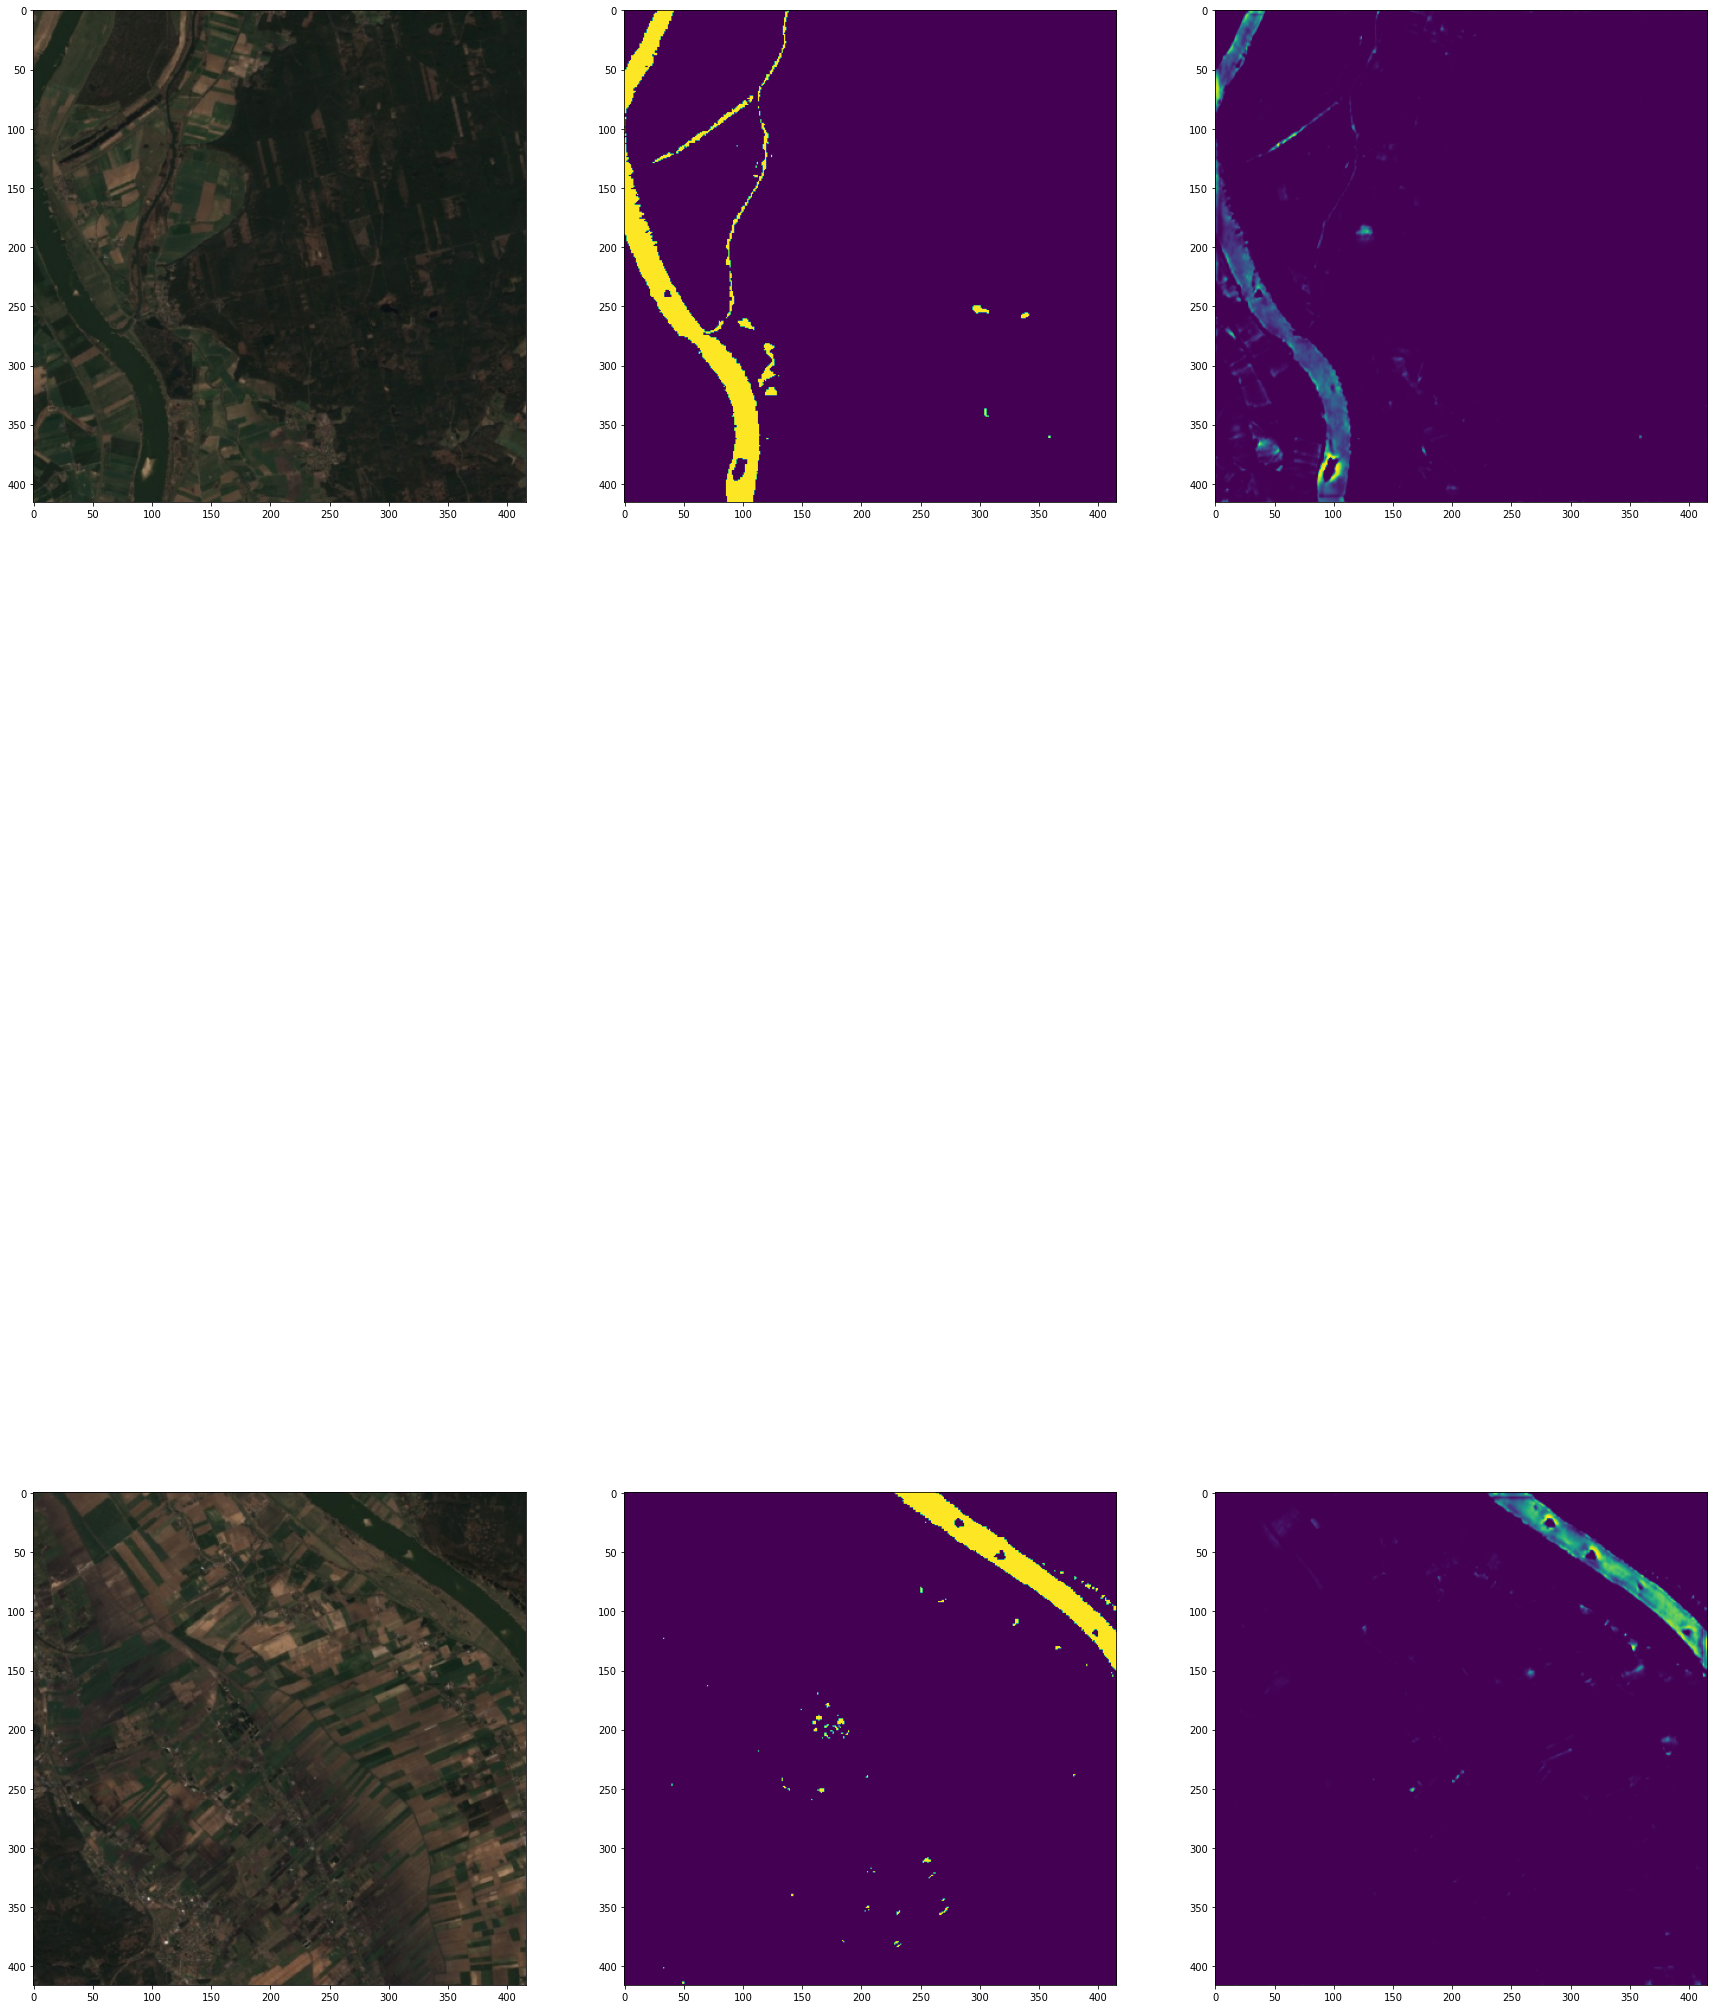

In [17]:
# visualize example segmentation

import math
#import helper
model.eval()   # Set model to evaluate mode
test_dataset = train_set#Dataset(x_test_dir, y_test_dir, PARAMS['input_size'])
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

labels = labels.data.cpu().numpy()
pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu()
#print(inputs.shape)
#print(labels)
#print(torch.sigmoid(torch.from_numpy(pred)).round())

# Change channel-order and make 3 channels for matplot
input_images_rgb = reverse_transform(inputs)#[reverse_transform(x) for x in inputs.cpu()]
#print(input_images_rgb.shape)
# Map each channel (i.e. class) to each color
target_masks_rgb = np.squeeze(labels)#[helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#print(target_masks_rgb.shape)
pred_rgb = np.squeeze(pred)#[helper.masks_to_colorimg(x) for x in pred]
#print(input_images_rgb)
plot_side_by_side(input_images_rgb, target_masks_rgb, pred_rgb)